# Insider trading

In [1]:
import finviz
import pandas as pd
import numpy as np
import quandl
import yfinance as yf
import matplotlib.pyplot as plt
import os

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
quandl.ApiConfig.api_key = "txYdeX4SX2NxGzzJYsLT"

**FORM 4** - https://www.sec.gov/files/forms-3-4-5.pdf

### securityadcode:
- Derivatives Holdings: D,DA,DD
- Non-Derivative Holdings:  N,NA,ND

### Transaction Code Transaction:
- **A** - Grant, award, or other acquisition of securities from the company (such as an option)
    - May indicate certainty on results about the company
- **K** - Equity swaps and similar hedging transactions
    - *IGNORE*
- **P** - Purchase of securities on an exchange or from another person
    - Indicates additional purchase (maybe good news or confidence about the ecompany)
- **S** - Sale of securities on an exchange or to another person
    - If lot of sales, may indicate loss of confidence about the company. Not good results
- **D** - Sale or transfer of securities back to the company
    - *IGNORE*
- **F** - Payment of exercise price or tax liability using portion of securities received from the company
    - *IGNORE* - Don't know about, may ignore them
- **M** - Exercise or conversion of derivative security received from the company (such as an option)
    - Mainly options  for employees. They buy (may be good indicator)
- **G** - Gift of securities by or to the insider
    - *IGNORE* Gift for the sons or things like that (maybe useful) Ignore for now
- **V** - A transaction voluntarily reported on Form 4
    - *IGNORE*
- **J** - Other (accompanied by a footnote describing the transaction)
    - *IGNORE*

### directorindirect
- **D**
- **I**


## Resources
https://www.sec.gov/edgar/search/#/q=WMT&dateRange=custom&startdt=2018-07-27&enddt=2018-12-31&category=form-cat2&locationType=located&locationCode=all&forms=3%252C4%252C5&page=1

**Latest** RSS Feed
- https://www.sec.gov/cgi-bin/browse-edgar?action=getcurrent&datea=&dateb=&company=&type=4&SIC=&State=&Country=&CIK=&owner=only&accno=&start=0&count=100
Can go deeper for the XML file


### WMT FORM 4 reports examples
https://www.sec.gov/Archives/edgar/data/0000104169/000112760218037607/xslF345X03/form4.xml
https://www.sec.gov/Archives/edgar/data/0000104169/000112760218037605/xslF345X03/form4.xml
https://www.sec.gov/Archives/edgar/data/0000104169/000112760218037606/xslF345X03/form4.xml

In [2]:
valid_transactioncode = ["A", "P", "S", "M"]

In [3]:
data = quandl.get_table("SHARADAR/SF2", paginate=True)
data = data.dropna(subset=["transactiondate"])
data = data.sort_values(["transactiondate"], ascending=False)
data = data[data["transactioncode"].isin(valid_transactioncode)]

In [4]:
data.groupby("transactioncode")["ticker"].count()

transactioncode
A    530
M    533
P     31
S    356
Name: ticker, dtype: int64

In [5]:
data.groupby("securityadcode")["ticker"].count()

securityadcode
DA    343
DD    264
NA    487
ND    356
Name: ticker, dtype: int64

In [6]:
data.groupby(["transactioncode", "securitytitle"])["ticker"].count()

transactioncode  securitytitle                                   
A                Class A Common Stock                                  1
                 Class B Common Stock                                 12
                 Common                                                5
                 Common Stock                                        163
                 Deferred Fee Phantom Stock Units                     11
                 Deferred Share Units                                  4
                 Deferred Shares                                       1
                 Deferred Stock Units                                  1
                 Disney Common Stock                                  10
                 Employee Stock Option (Right to Buy)                  9
                 Employee Stock Options                                1
                 Non-Qualified Stock Option (right to buy)             3
                 Performance Share Award                  

## Table joining

In [7]:
symbols = data["ticker"].unique()

In [8]:
ticker2name = data[["ticker", "issuername"]].drop_duplicates().set_index("ticker").to_dict()["issuername"]

In [9]:
data.groupby(["ticker", "issuername"])["ticker"].count()

ticker  issuername               
AAPL    APPLE INC                     33
AXP     AMERICAN EXPRESS CO           19
BA      BOEING CO                     16
CAT     CATERPILLAR INC               37
CSCO    CISCO SYSTEMS INC             39
CVX     CHEVRON CORP                  33
DIS     WALT DISNEY CO               103
GE      GENERAL ELECTRIC CO           48
GS      GOLDMAN SACHS GROUP INC        6
HD      HOME DEPOT INC                20
IBM     INTERNATIONAL BUSINESS MA     45
INTC    INTEL CORP                    65
JNJ     JOHNSON JOHNSON               35
JPM     JPMORGAN CHASE CO             20
KO      COCA COLA CO                  52
MCD     MCDONALDS CORP                22
MMM     3M CO                         14
MRK     MERCK CO INC                  40
MSFT    MICROSOFT CORP                58
NKE     NIKE INC                      25
PFE     PFIZER INC                    52
PG      PROCTER GAMBLE CO            197
TRV     TRAVELERS COMPANIES INC        7
TSLA    TESLA INC      

In [10]:
dict_frames = {}
for symbol in symbols:
    curr_table = pd.pivot_table(data[data["ticker"]==symbol], 
                                values=["transactionshares", "transactionpricepershare", "transactionvalue"], 
                                index=['transactiondate'],
                                columns=['transactioncode'], aggfunc={"transactionshares": np.sum, 
                                                             "transactionpricepershare": np.mean,
                                                             "transactionvalue": np.sum})
    curr_table.columns = [code + "_" + transaction for transaction, code in curr_table.columns]
    serie = yf.Ticker(symbol)
    stock_df = serie.history(start=data["transactiondate"].min(), 
                             end=data["transactiondate"].max(), 
                             interval="1d")
    dict_frames[symbol] = stock_df.merge(curr_table, how="left", left_index=True, right_index=True)    

In [12]:
dict_frames["WMT"]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,S_transactionpricepershare,A_transactionshares,S_transactionshares,A_transactionvalue,S_transactionvalue
Date,,,,,,,,,,,,
2018-08-31,92.95,93.19,91.90,92.63,6324700,0.00,0,NaN,NaN,NaN,NaN,NaN
2018-09-04,92.57,93.02,92.03,92.14,8280700,0.00,0,NaN,NaN,NaN,NaN,NaN
2018-09-05,92.44,93.57,92.14,93.36,9474600,0.00,0,95.705000,NaN,-691500.0,NaN,66180009.0
2018-09-06,93.28,93.46,92.77,93.20,6150800,0.00,0,96.305000,NaN,-12111.0,NaN,1166350.0
2018-09-07,92.57,93.23,92.42,92.60,6672400,0.00,0,NaN,NaN,NaN,NaN,NaN
2018-09-10,92.87,93.91,92.85,93.63,8332600,0.00,0,NaN,NaN,NaN,NaN,NaN
2018-09-11,93.99,94.37,93.24,93.38,6463500,0.00,0,97.239500,NaN,-1800000.0,NaN,174464697.0
2018-09-12,93.01,93.48,92.70,92.73,5900000,0.00,0,96.260000,NaN,-1291920.0,NaN,124360218.0
2018-09-13,92.11,92.40,91.71,91.91,7652900,0.00,0,95.228000,NaN,-1594080.0,NaN,151801050.0


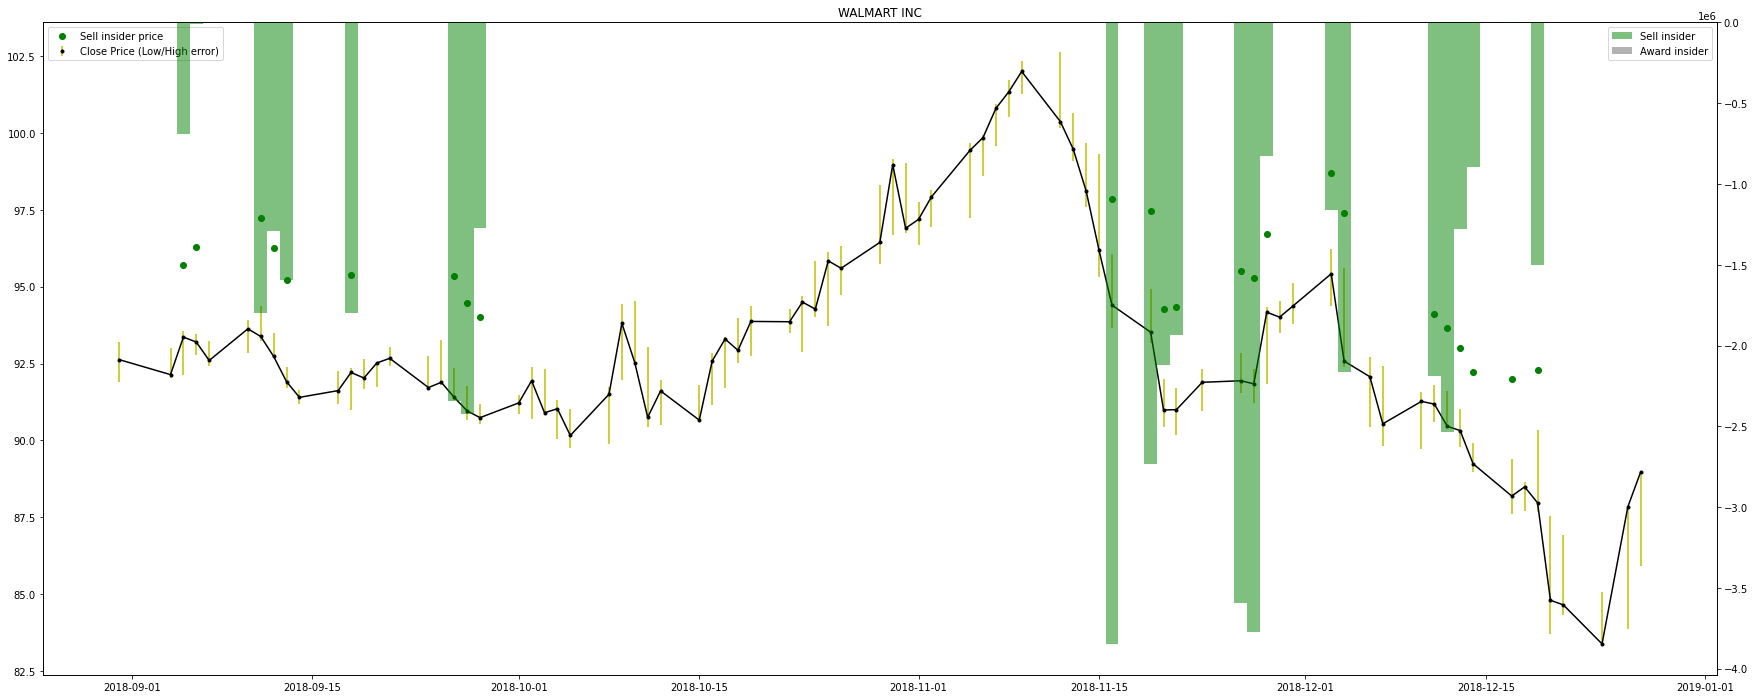

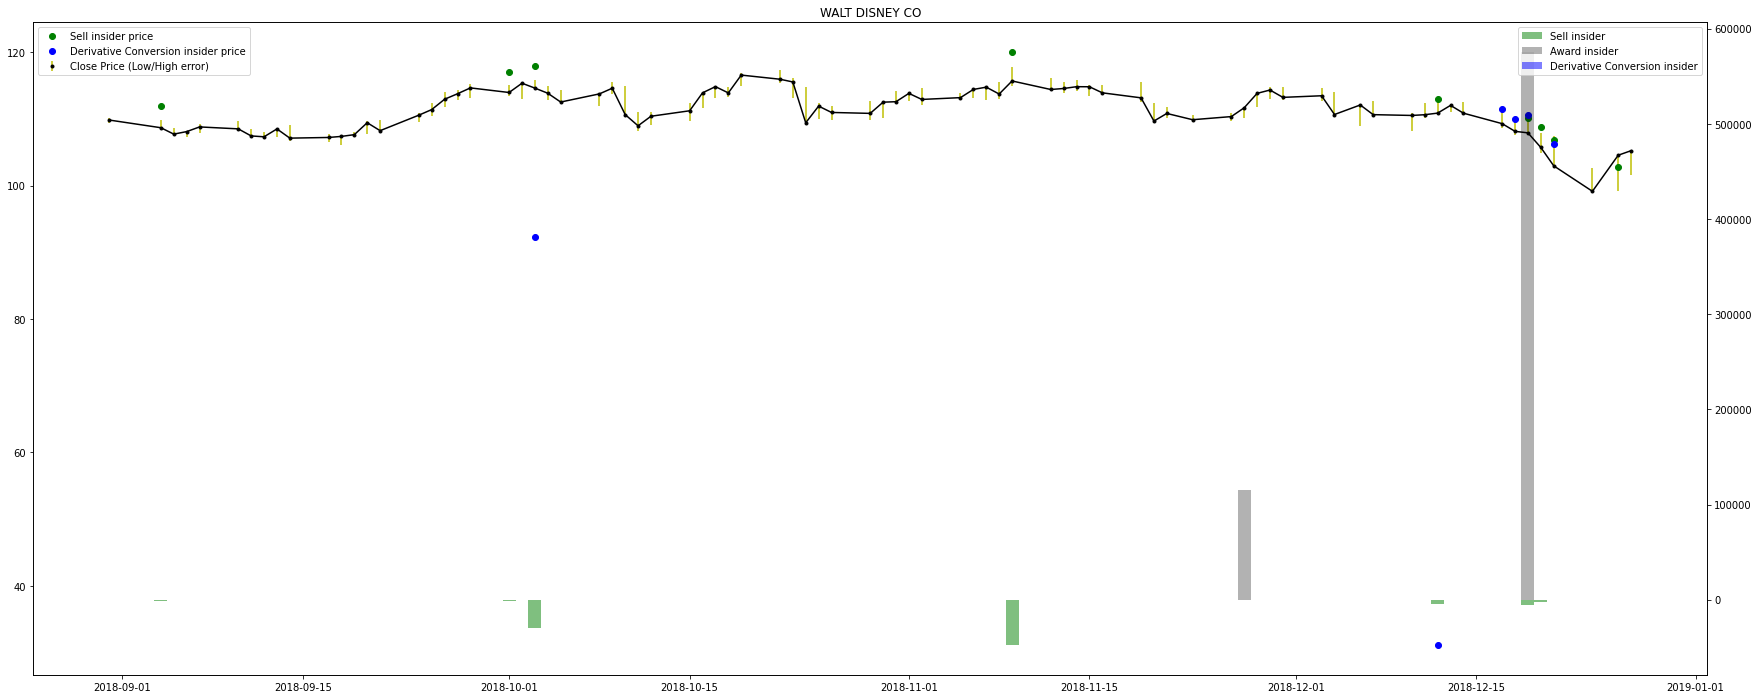

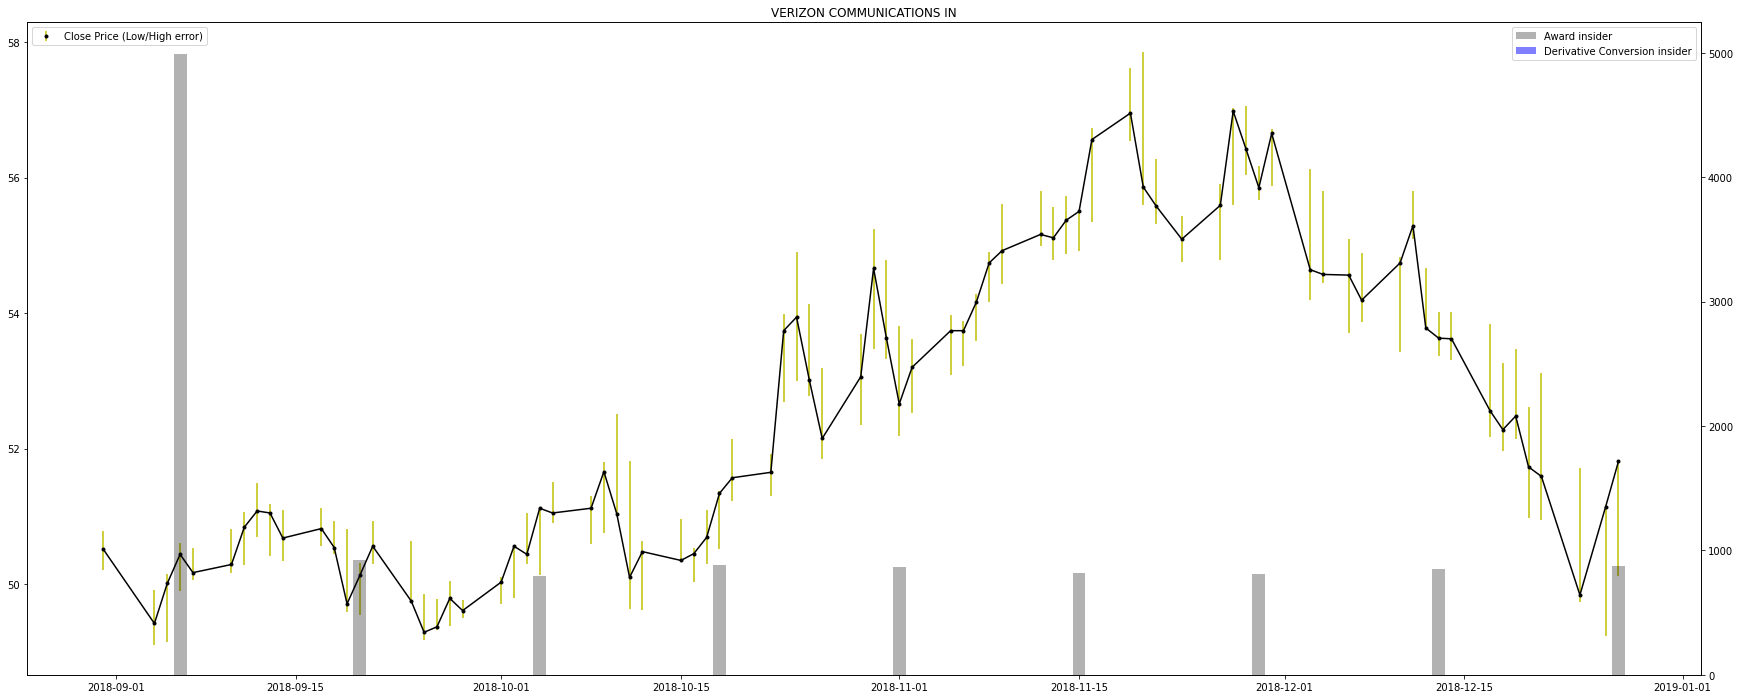

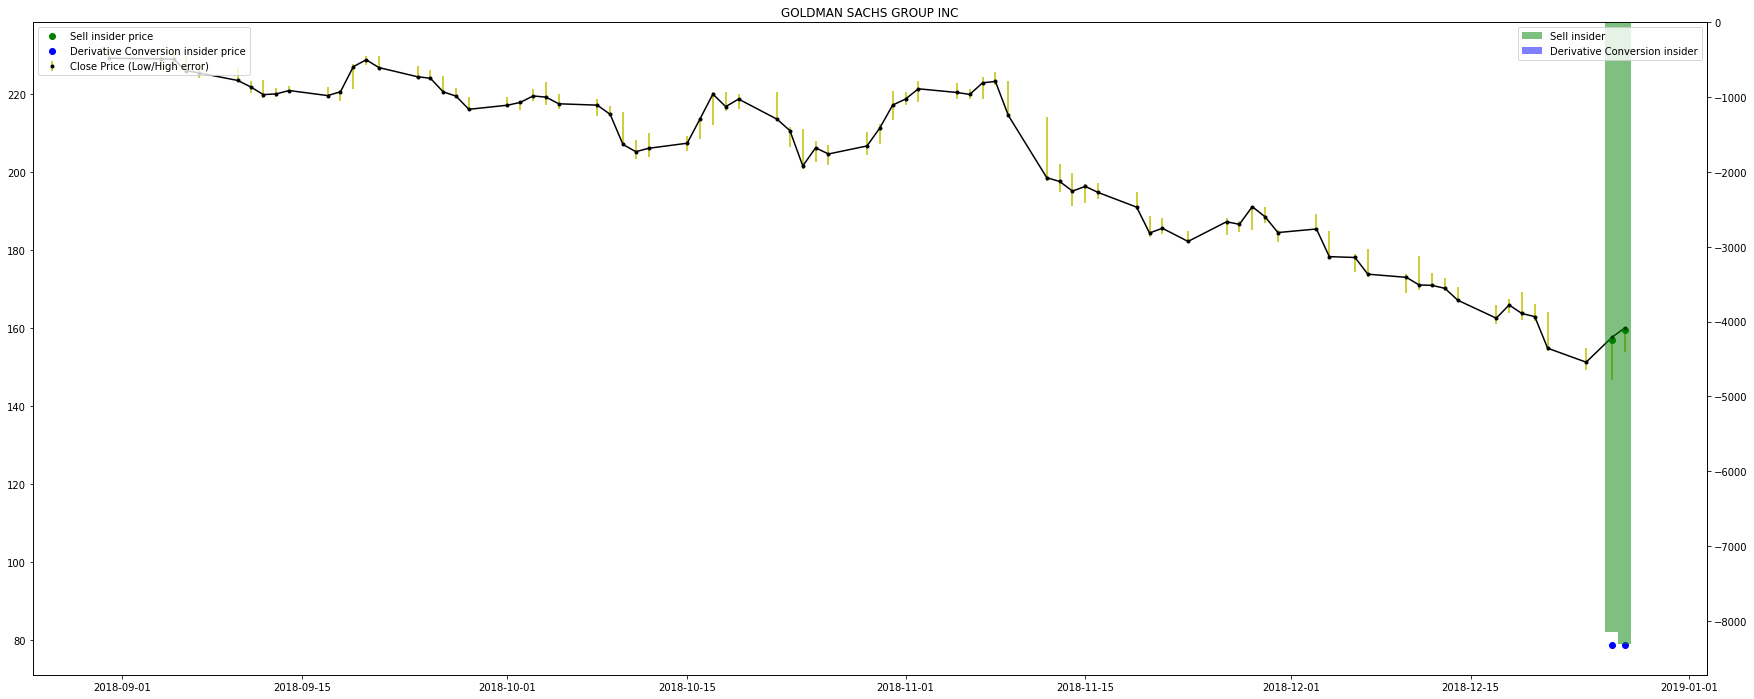

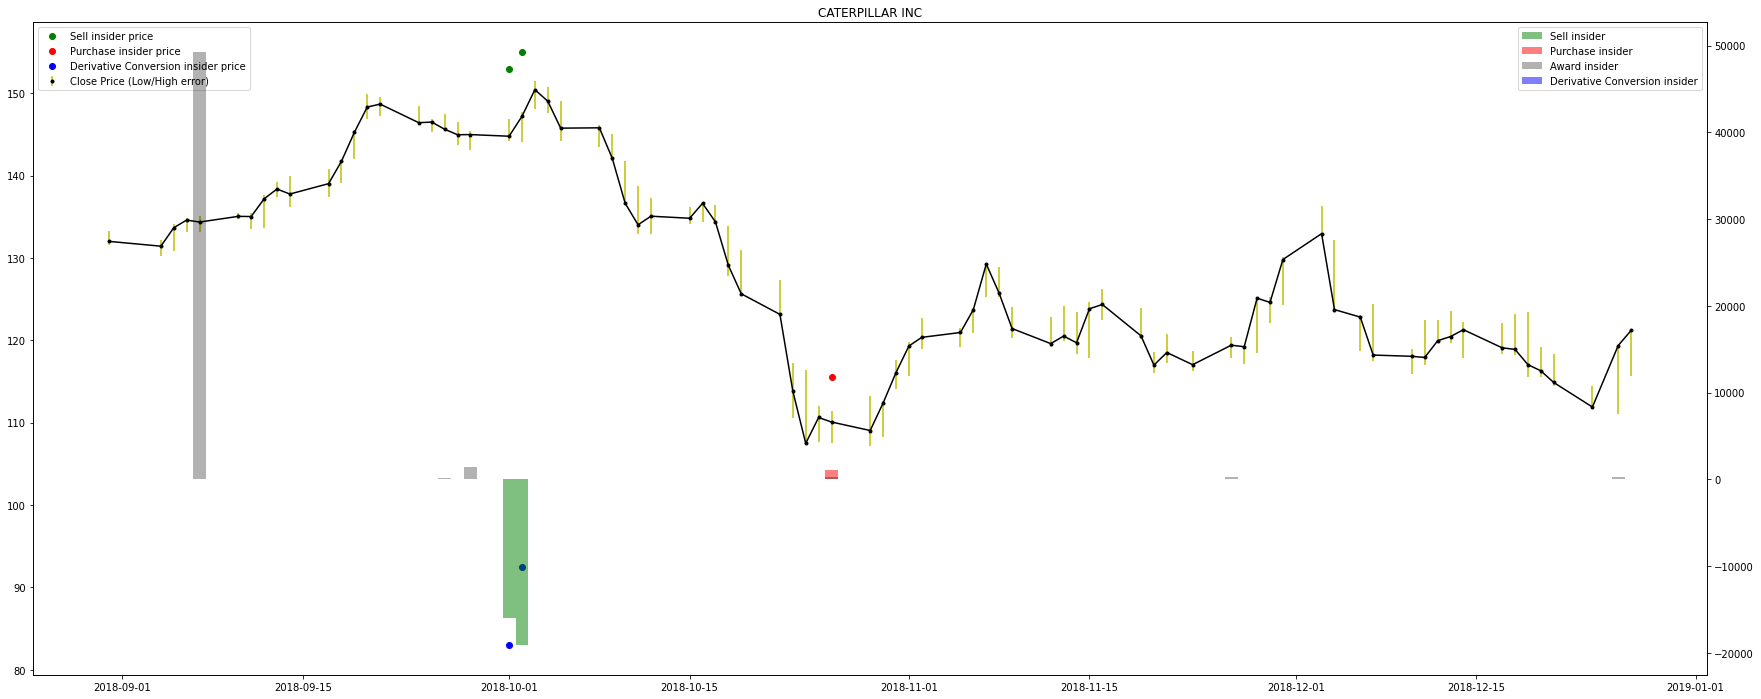

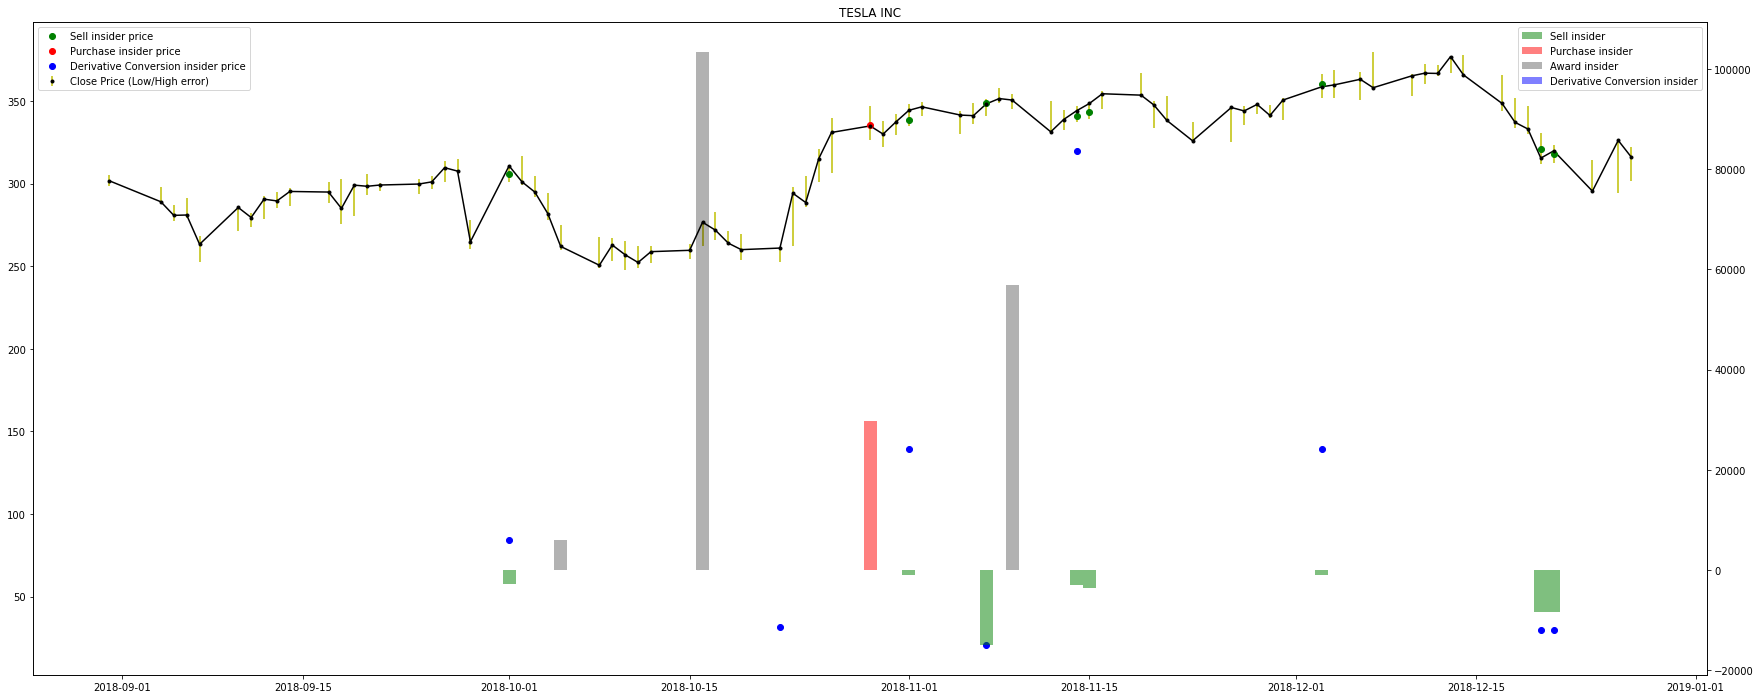

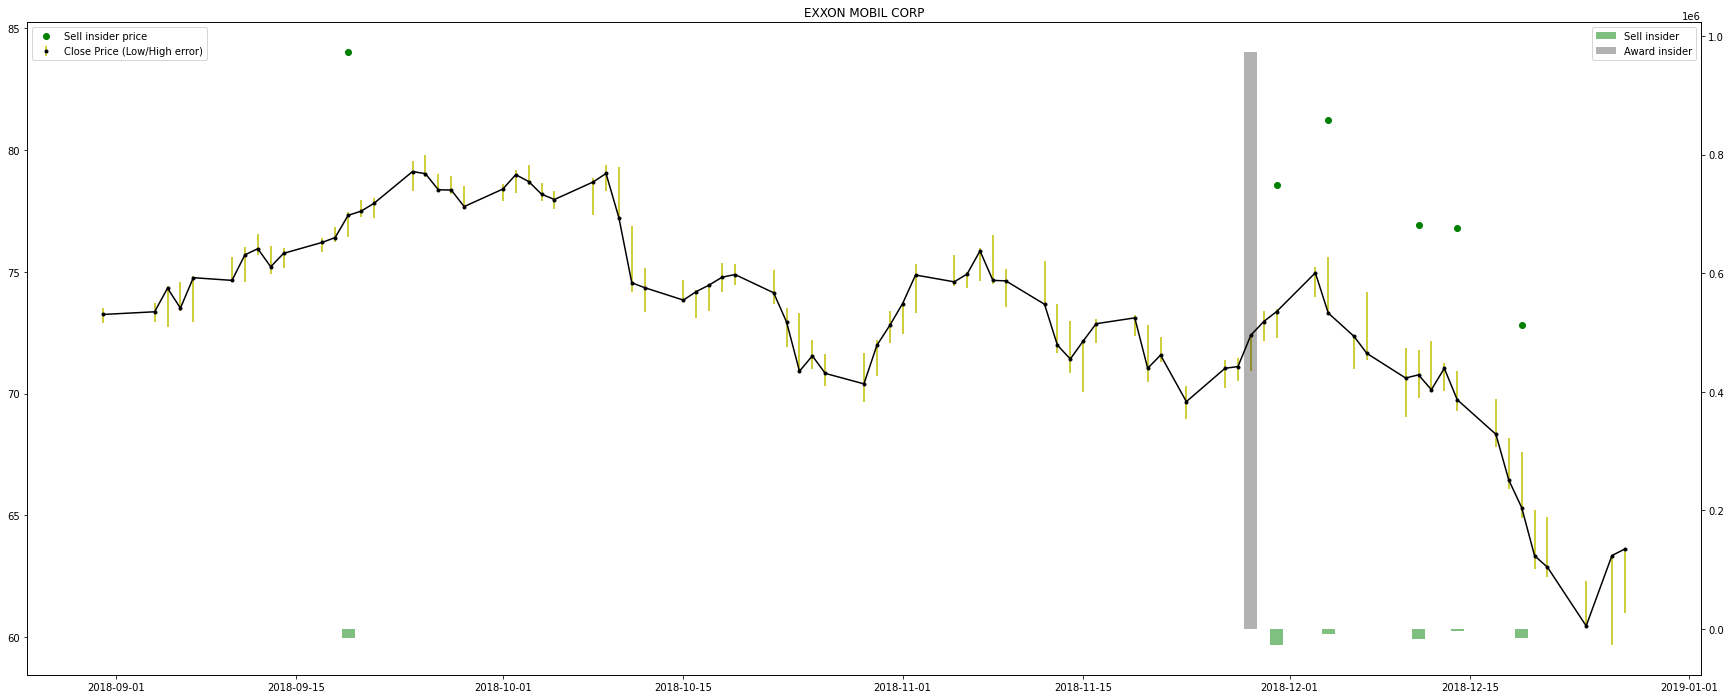

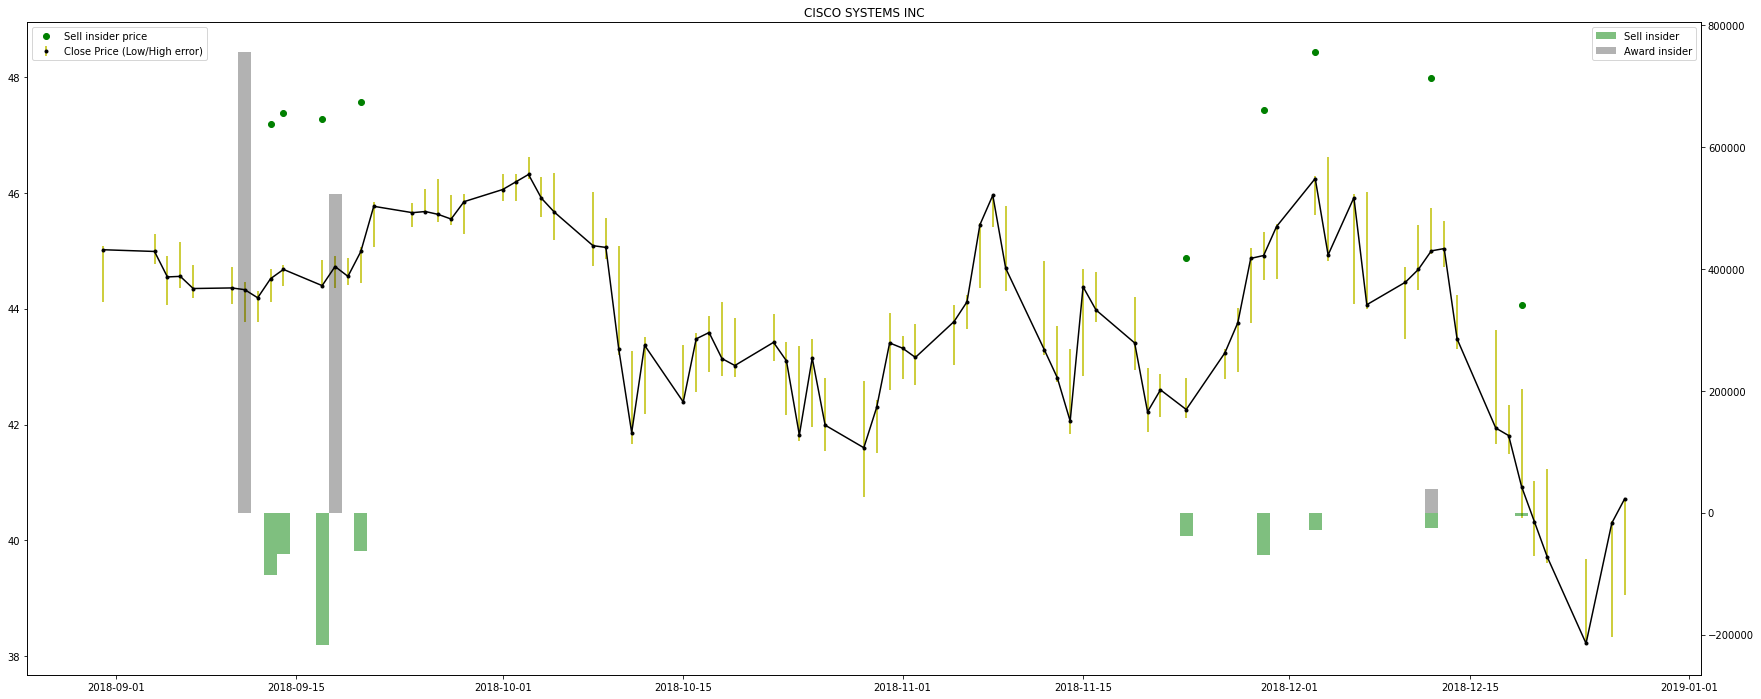

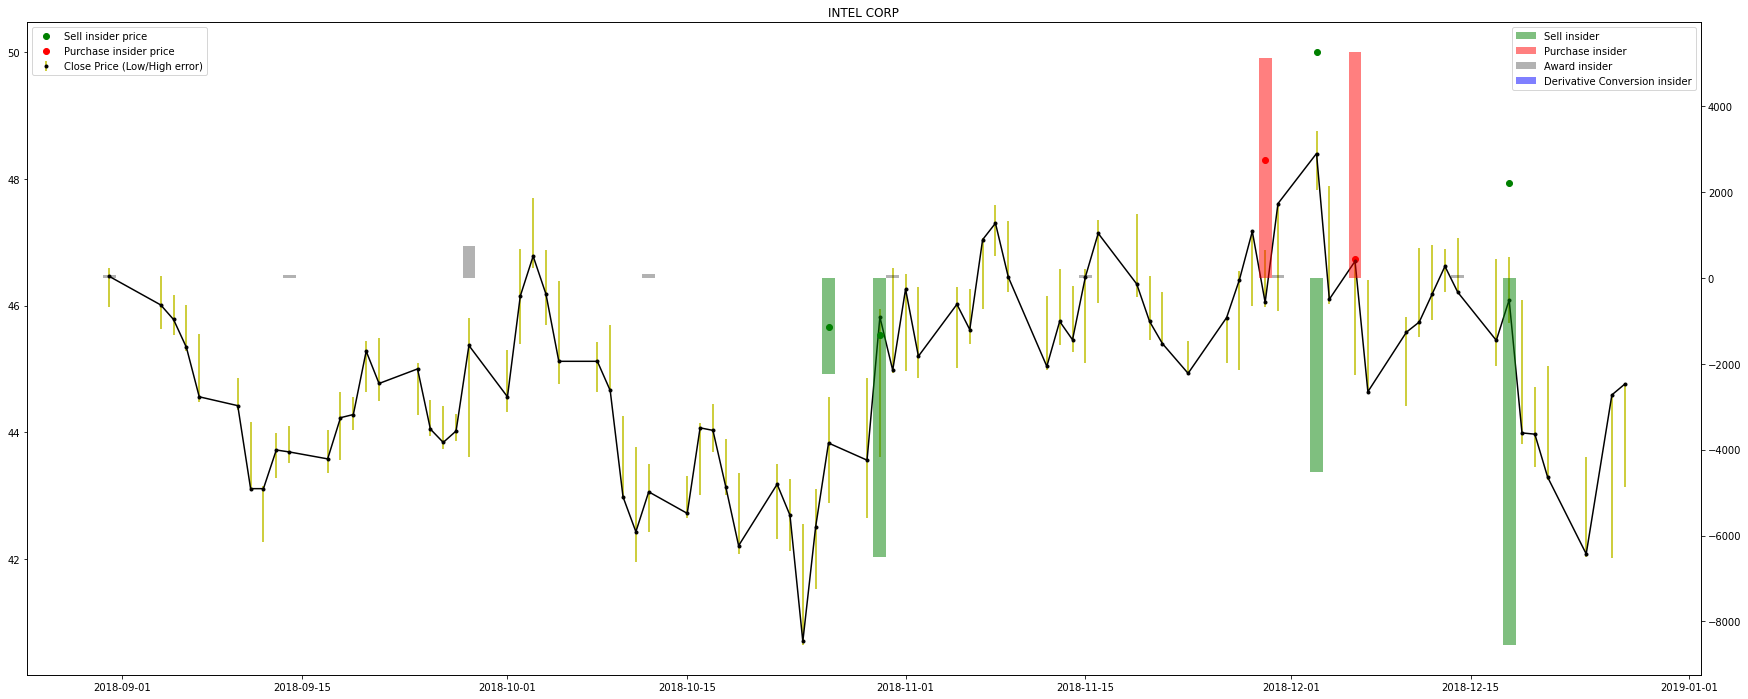

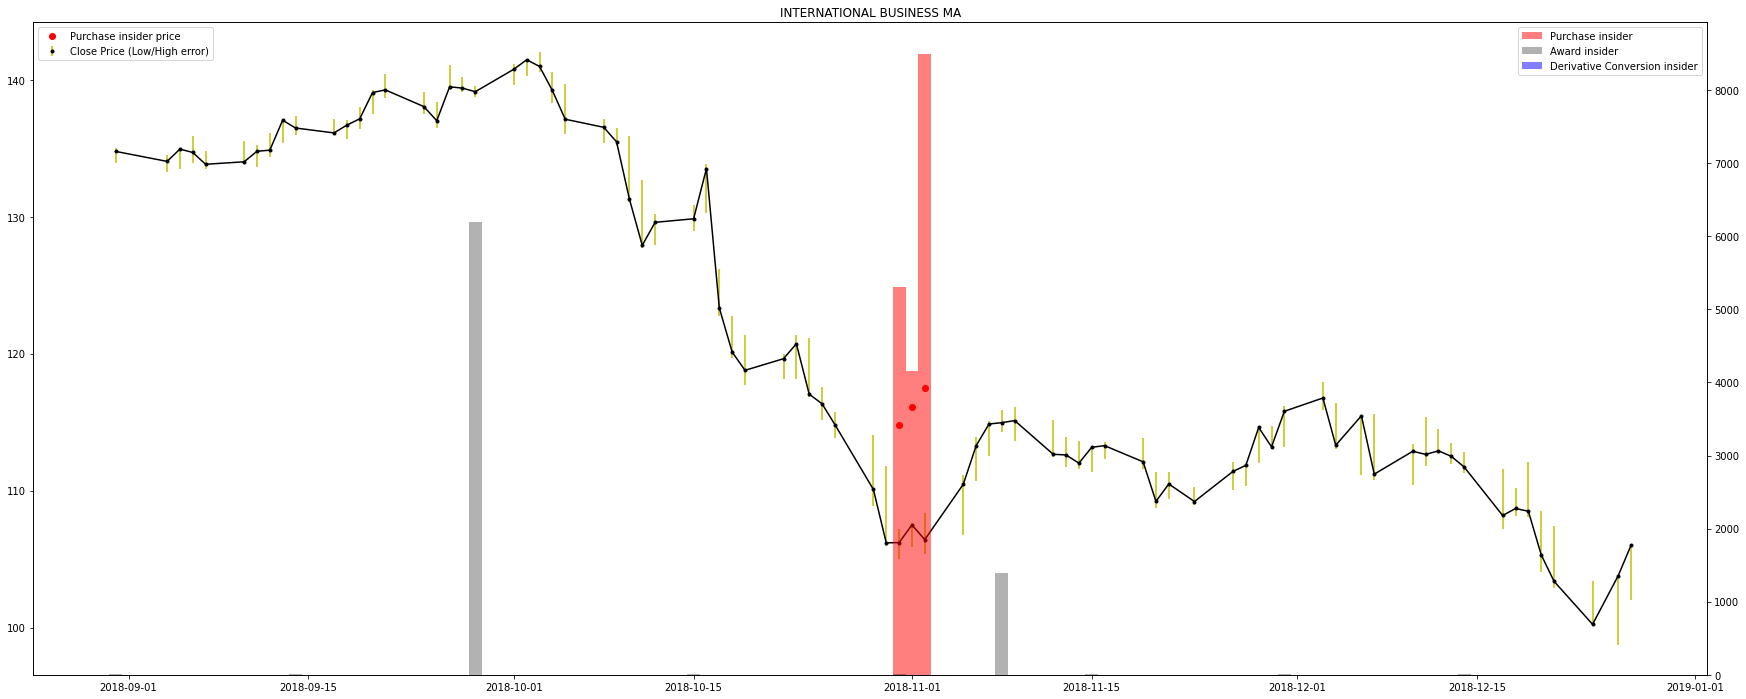

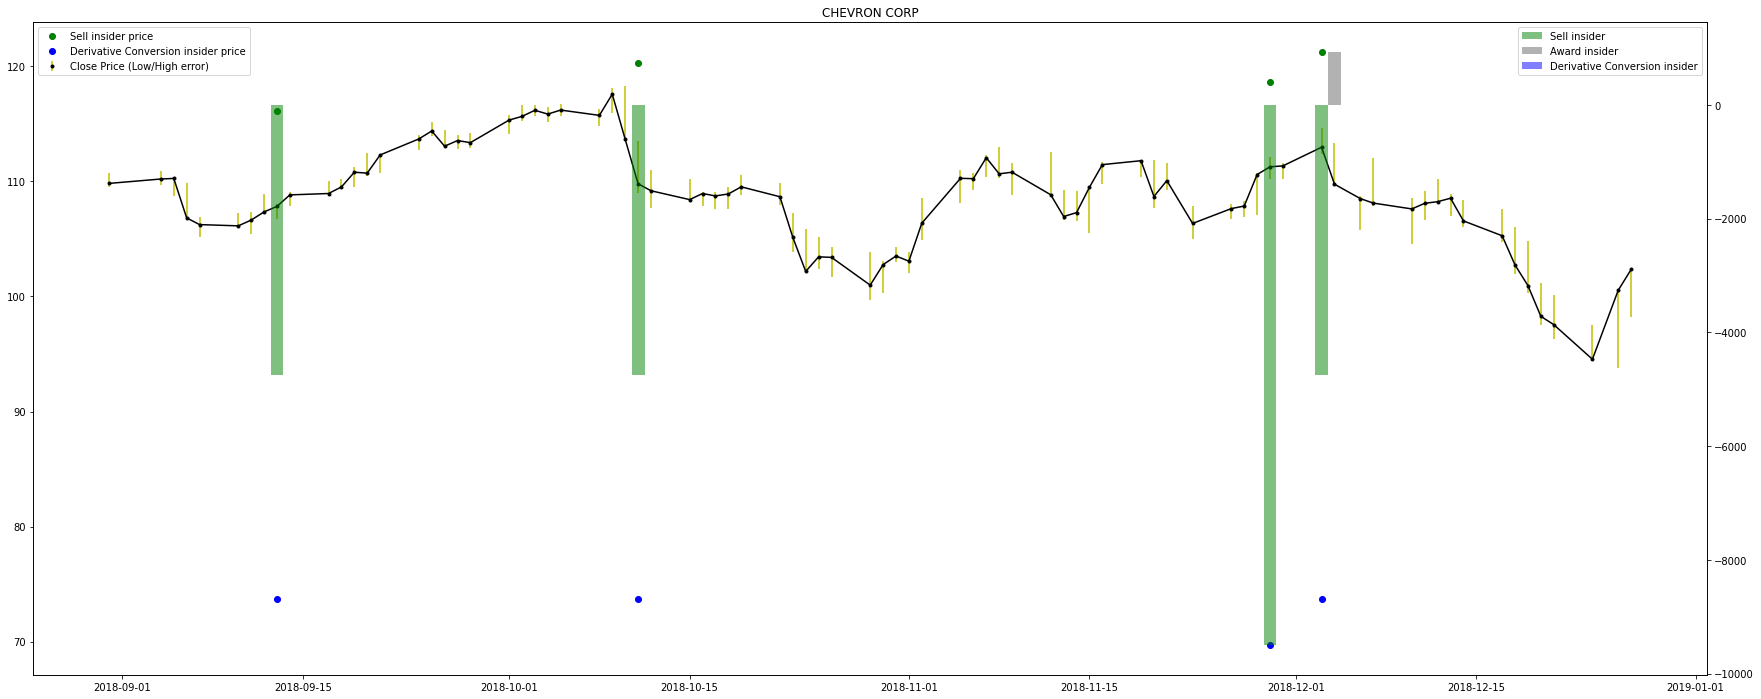

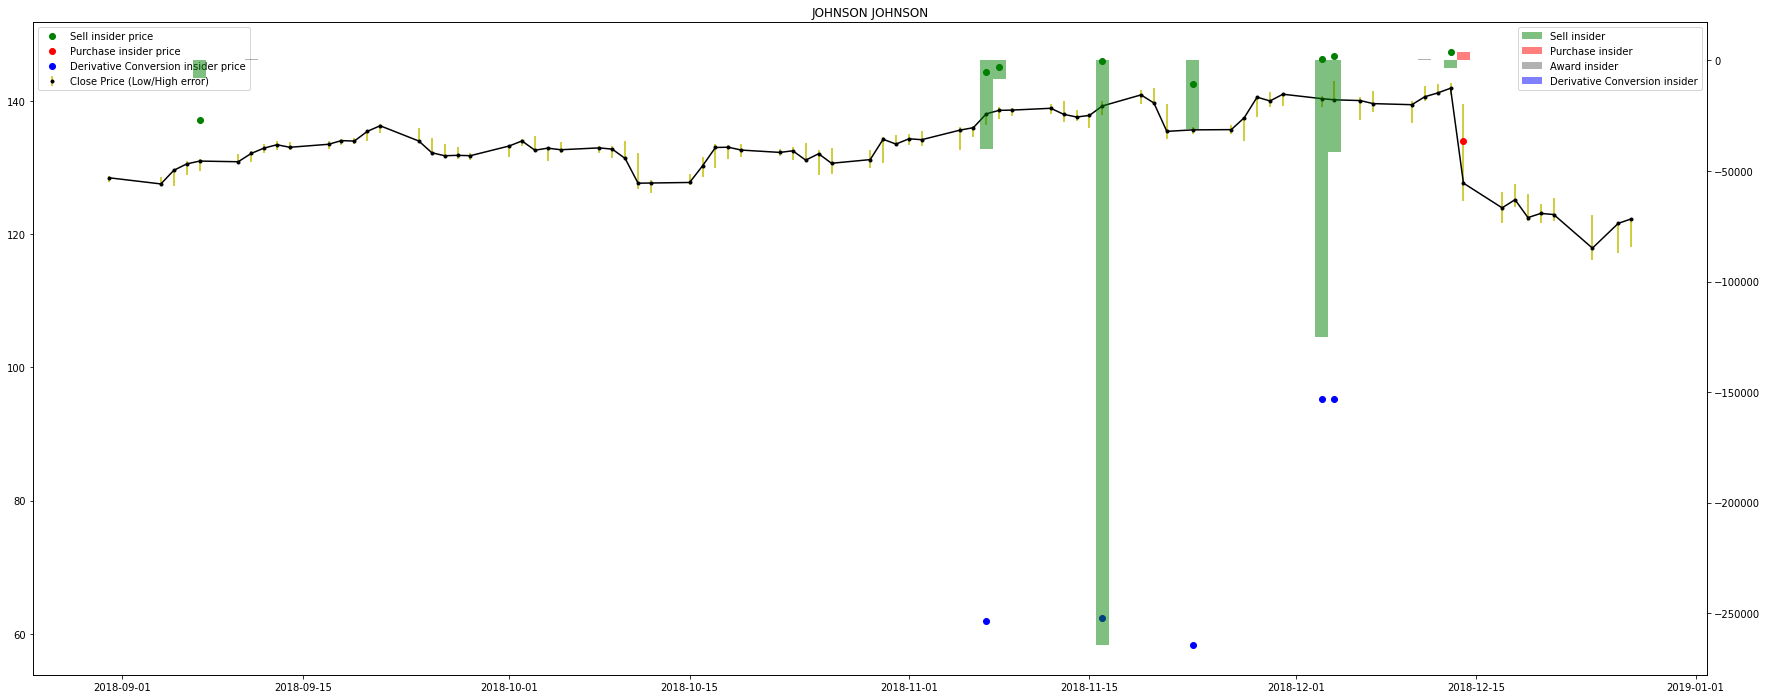

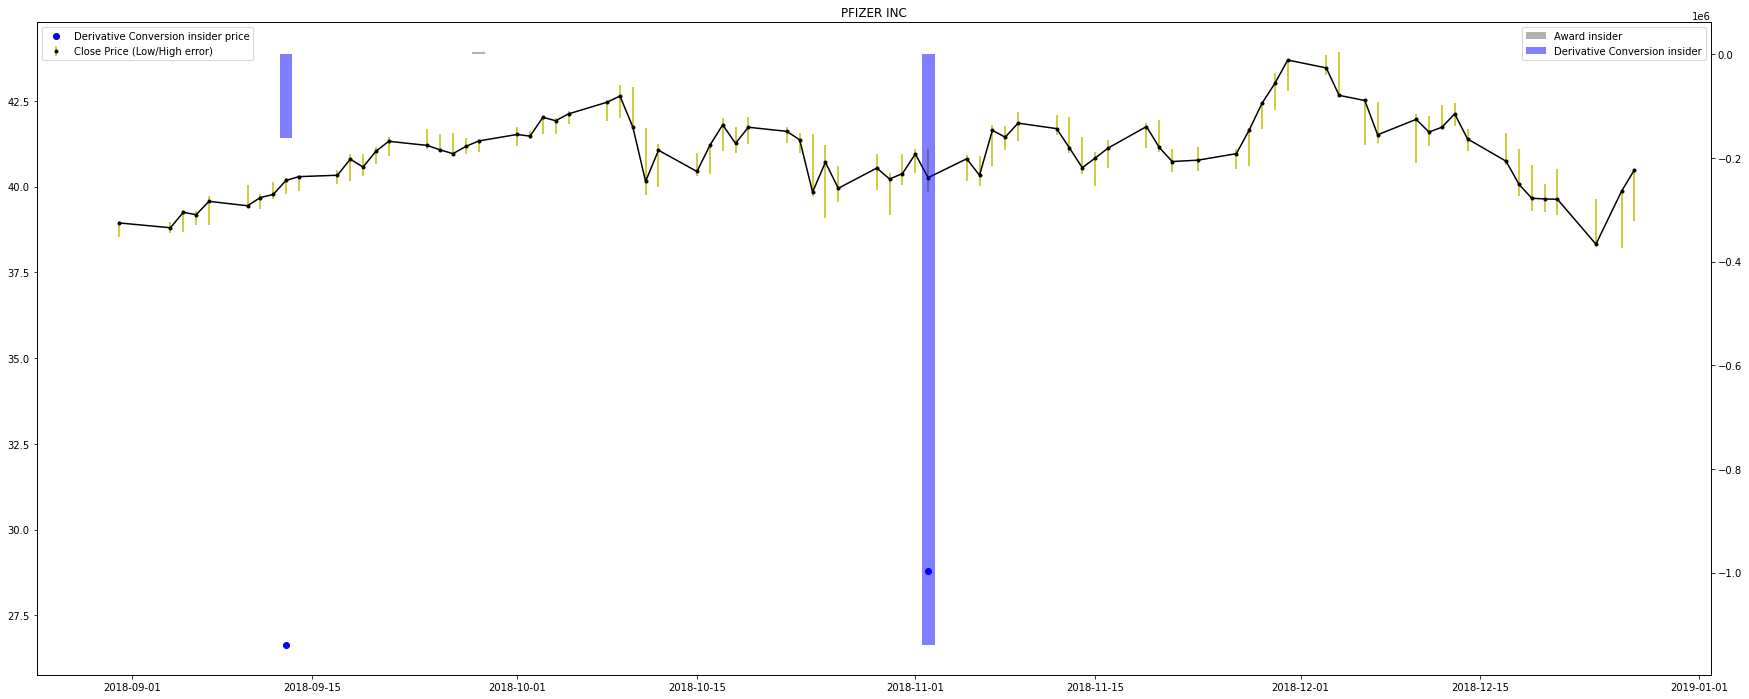

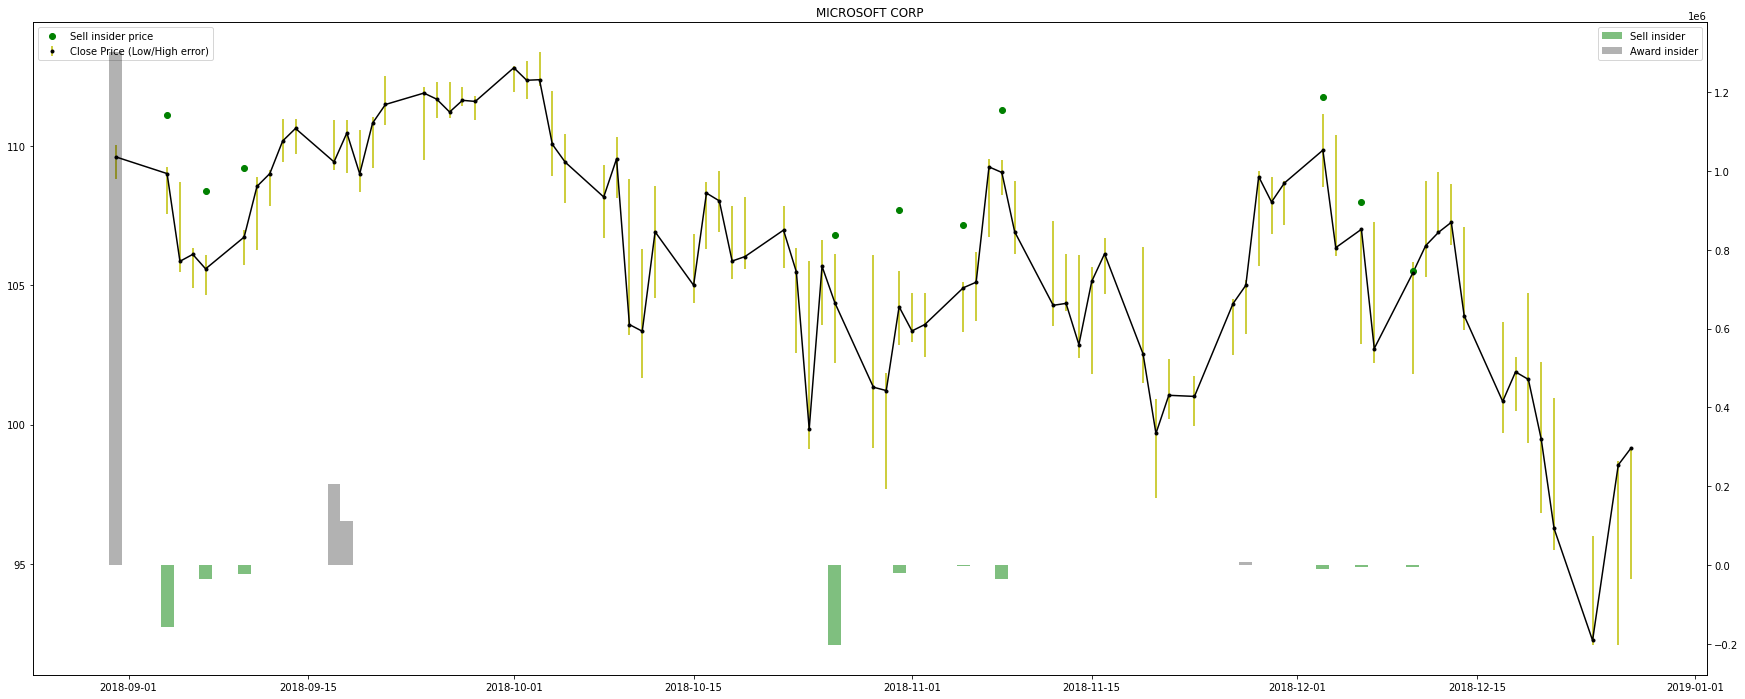

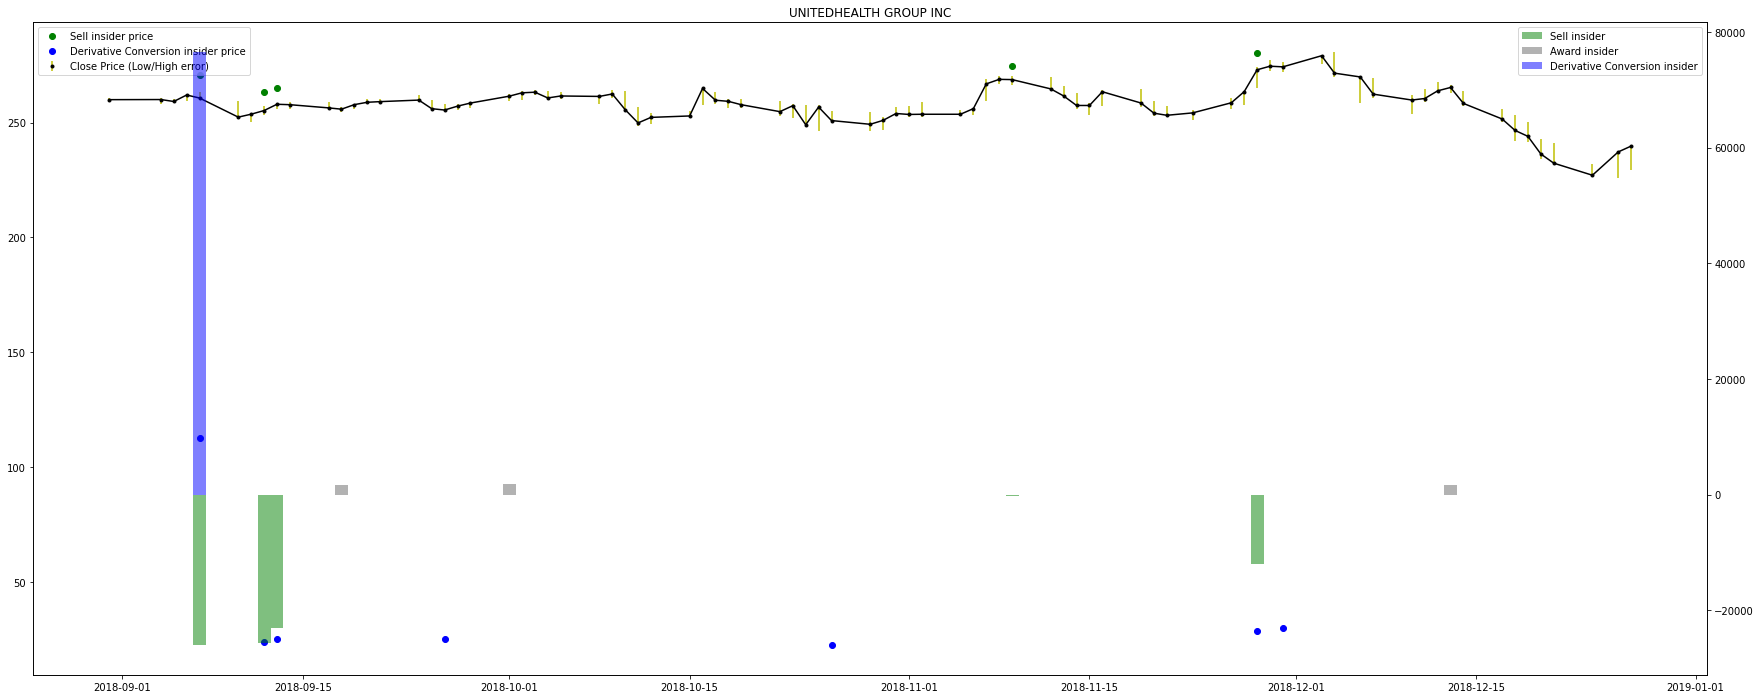

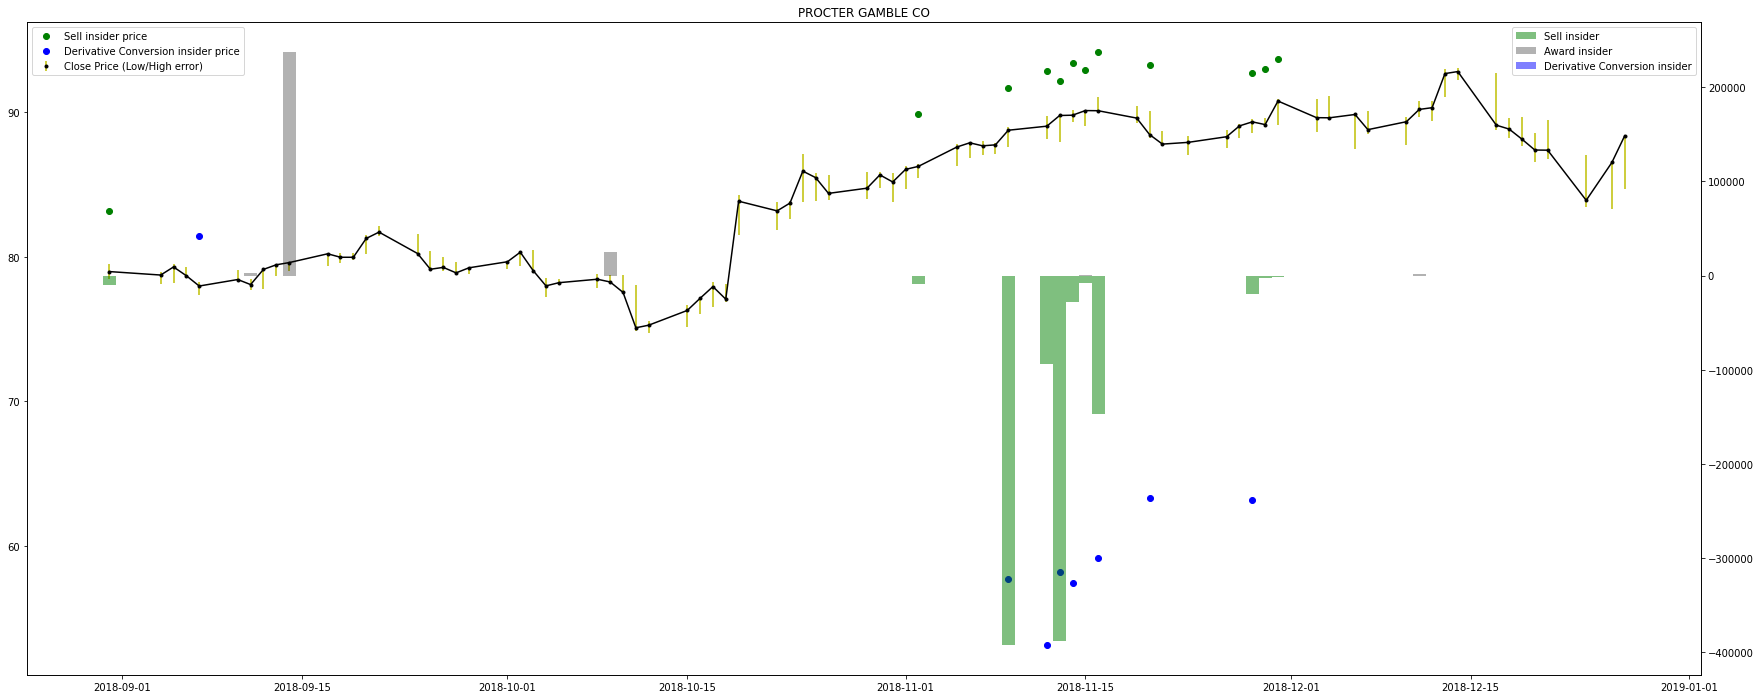

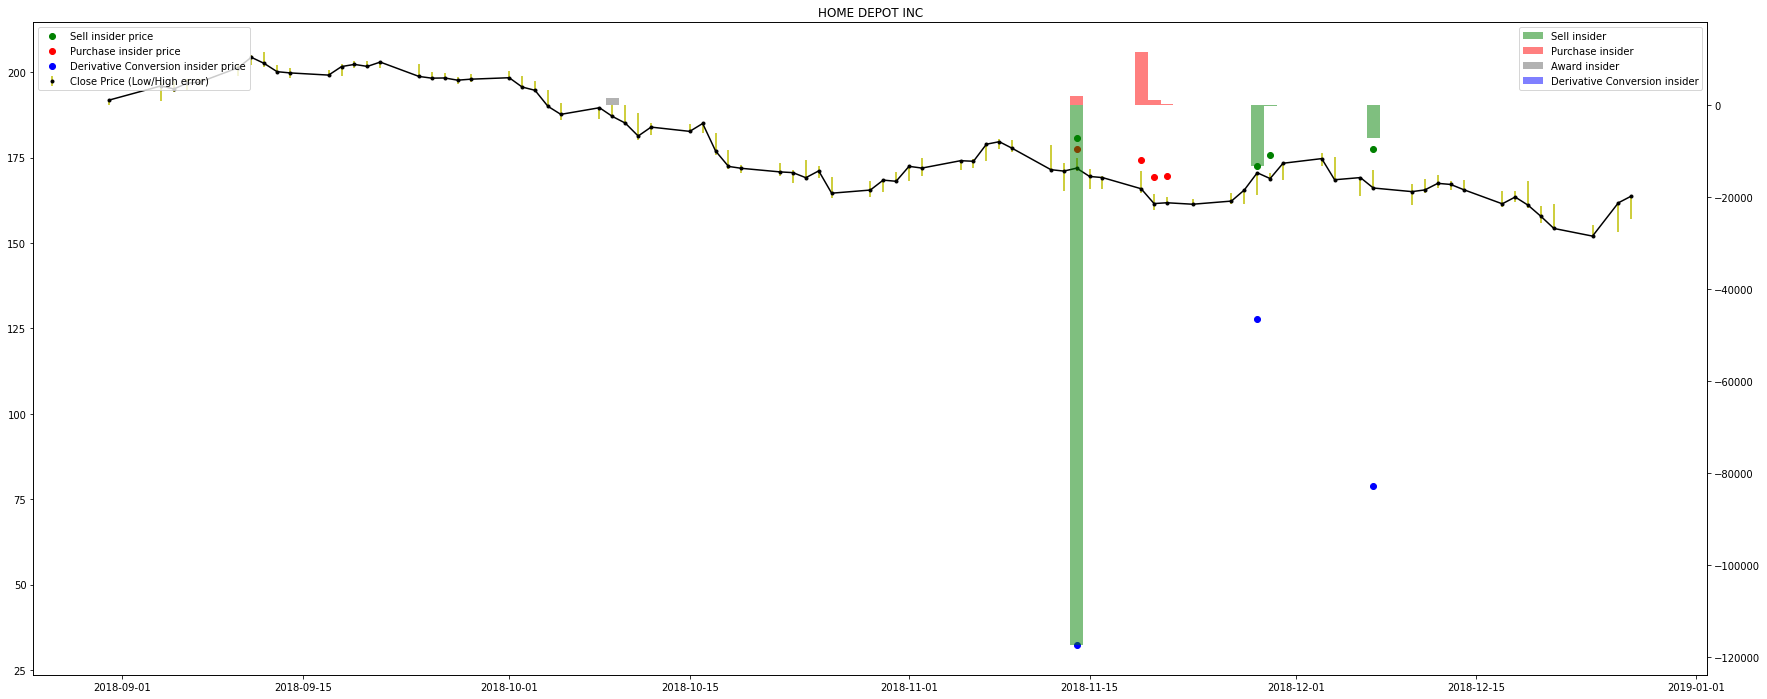

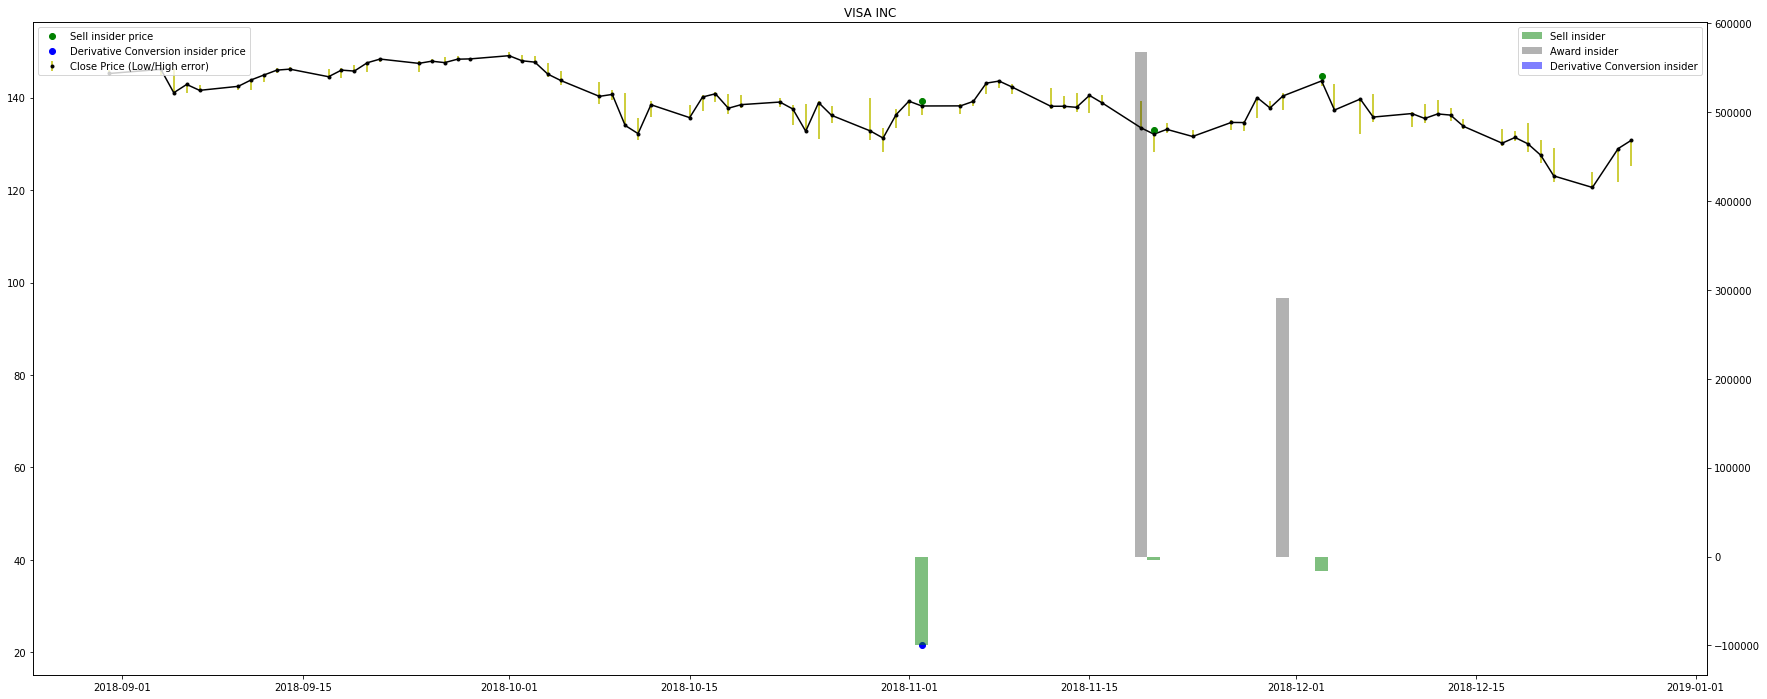

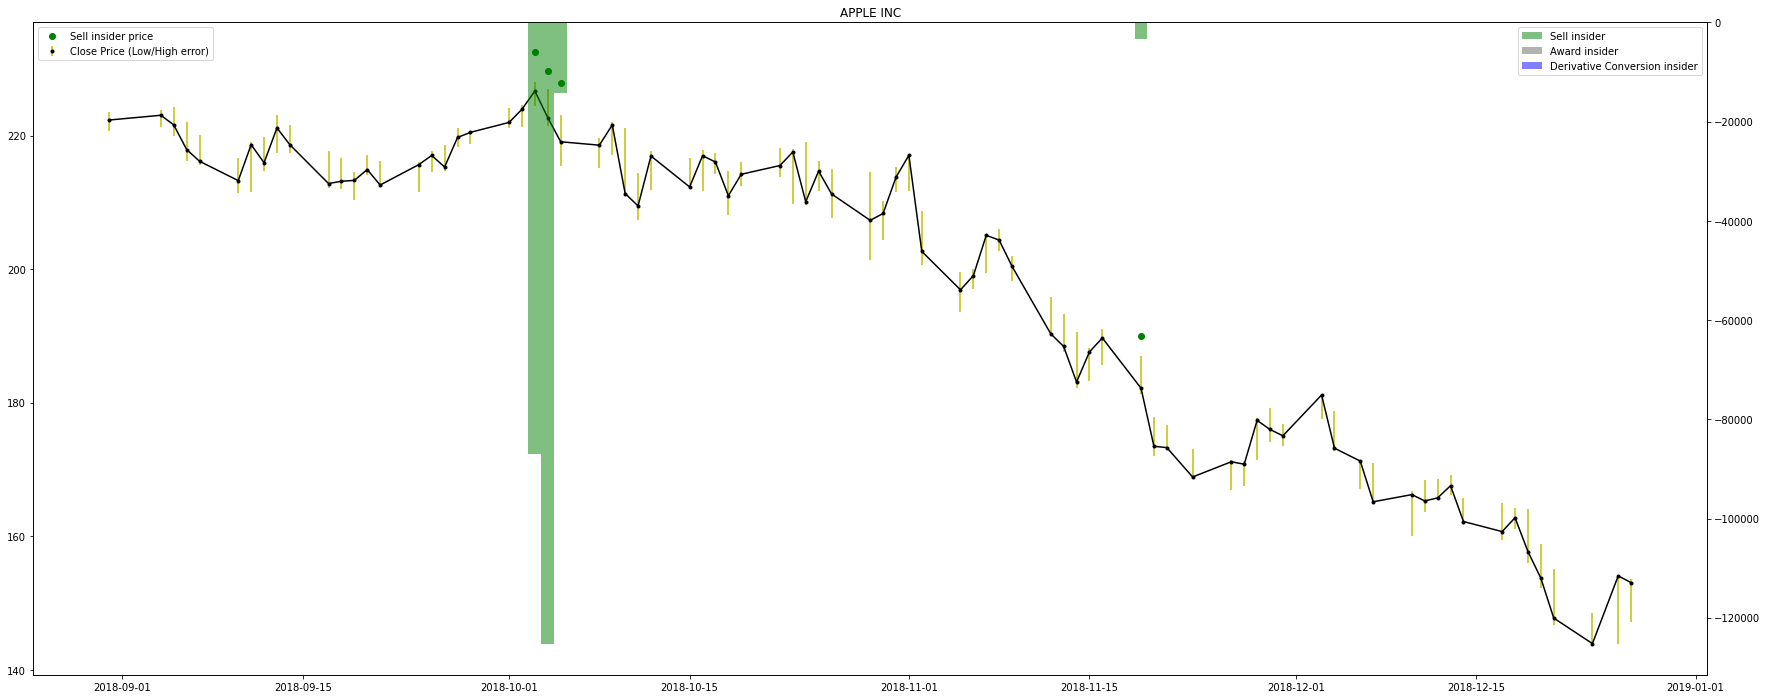

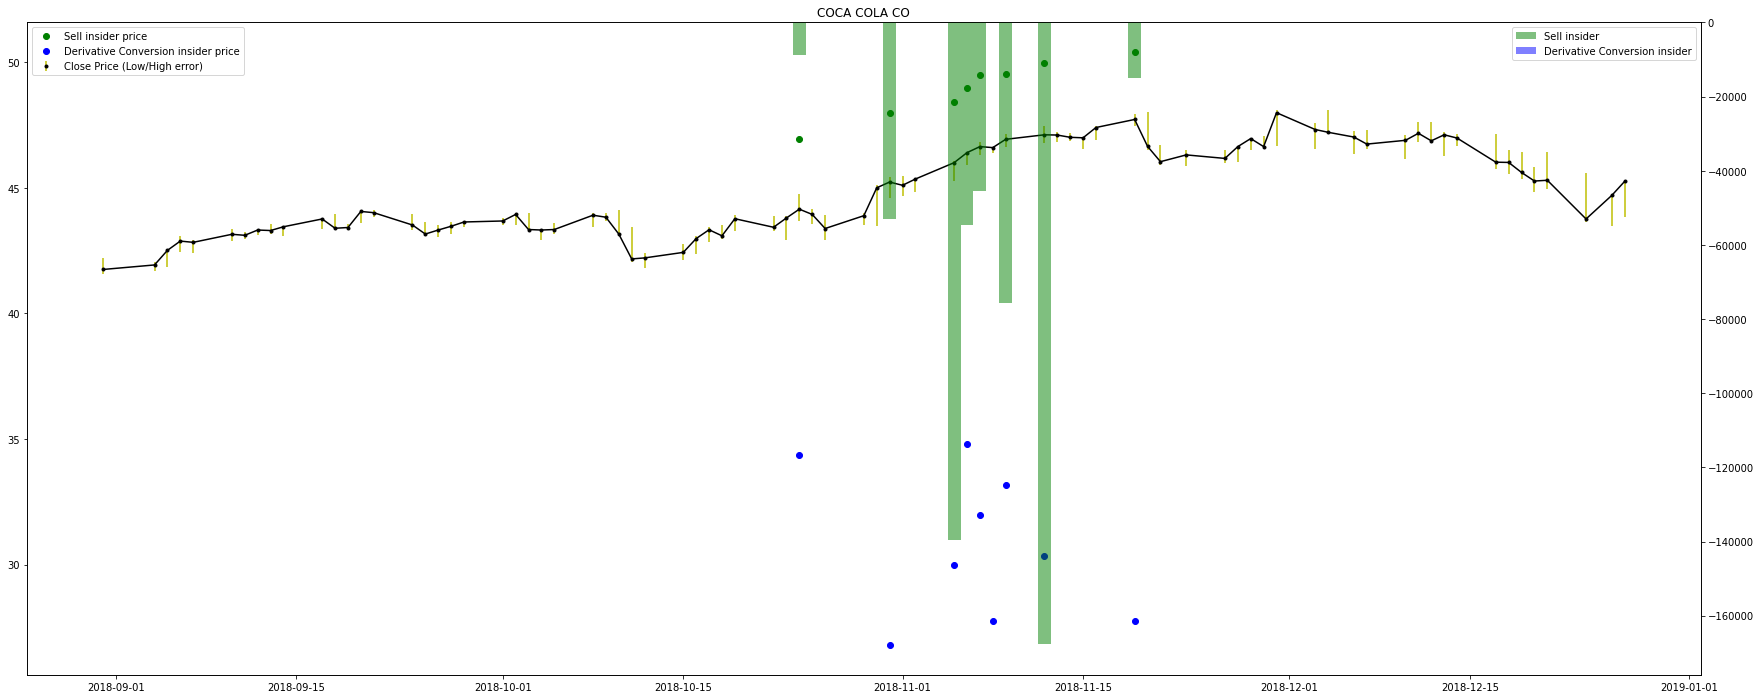

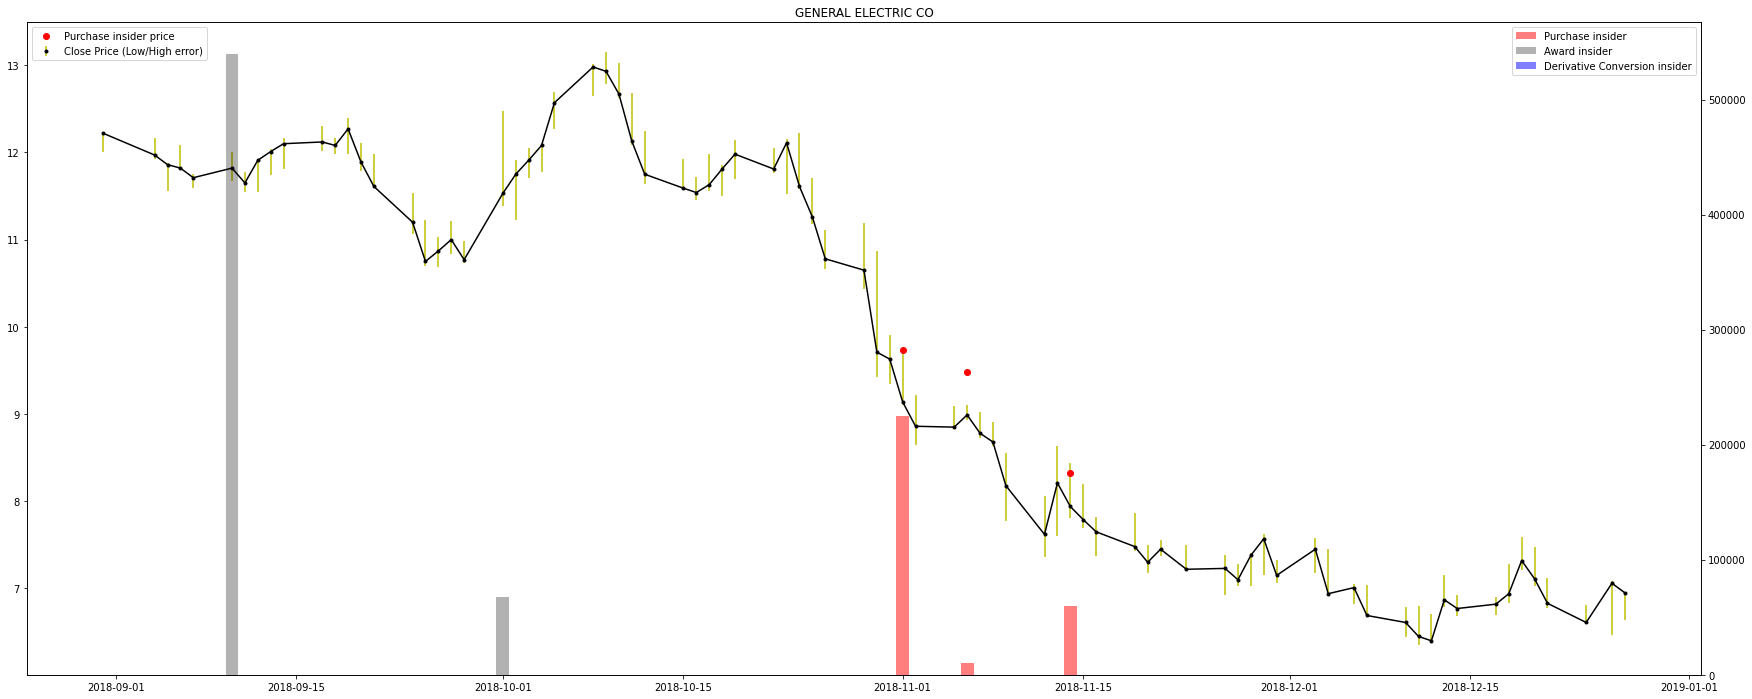

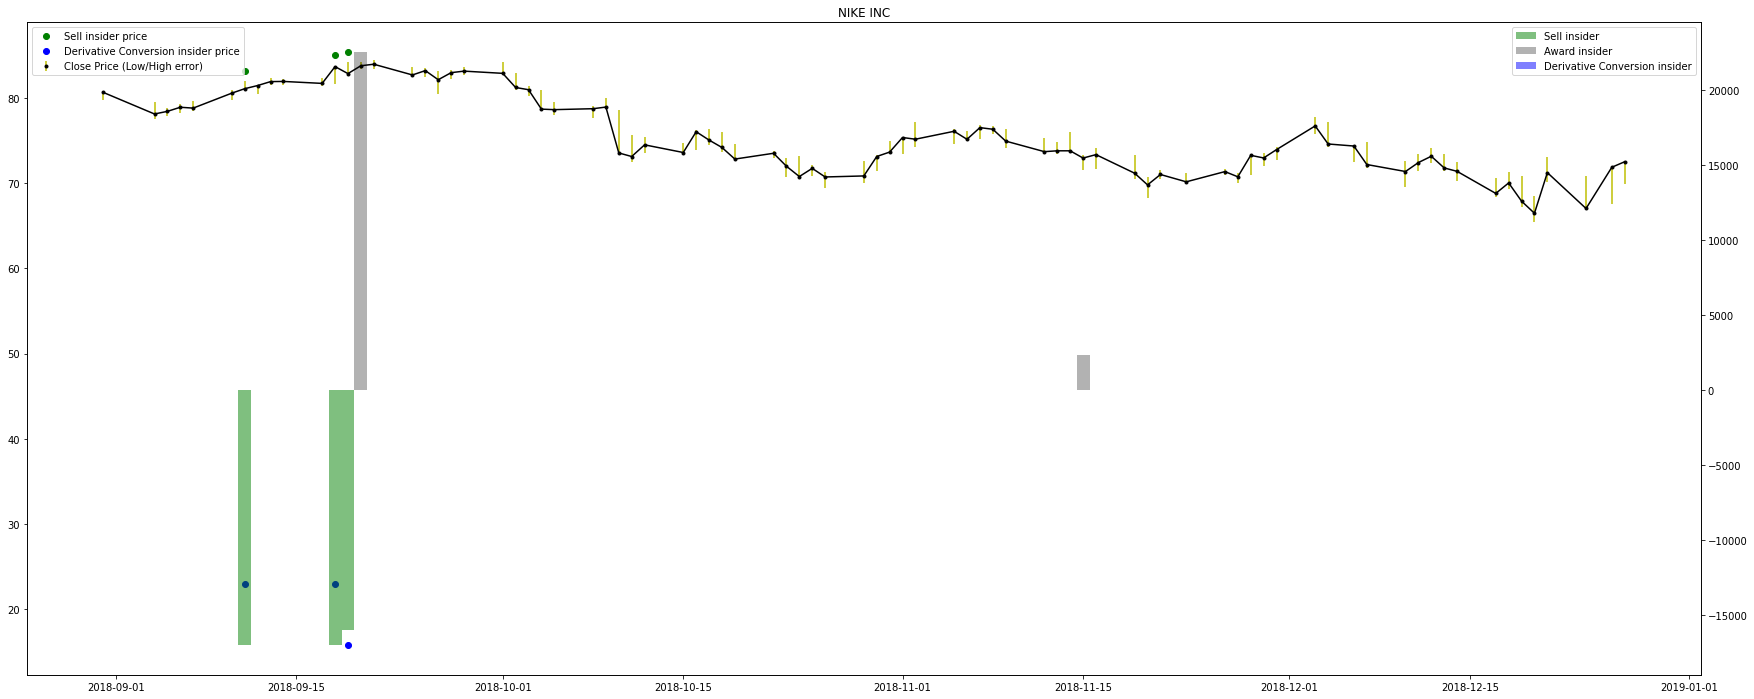

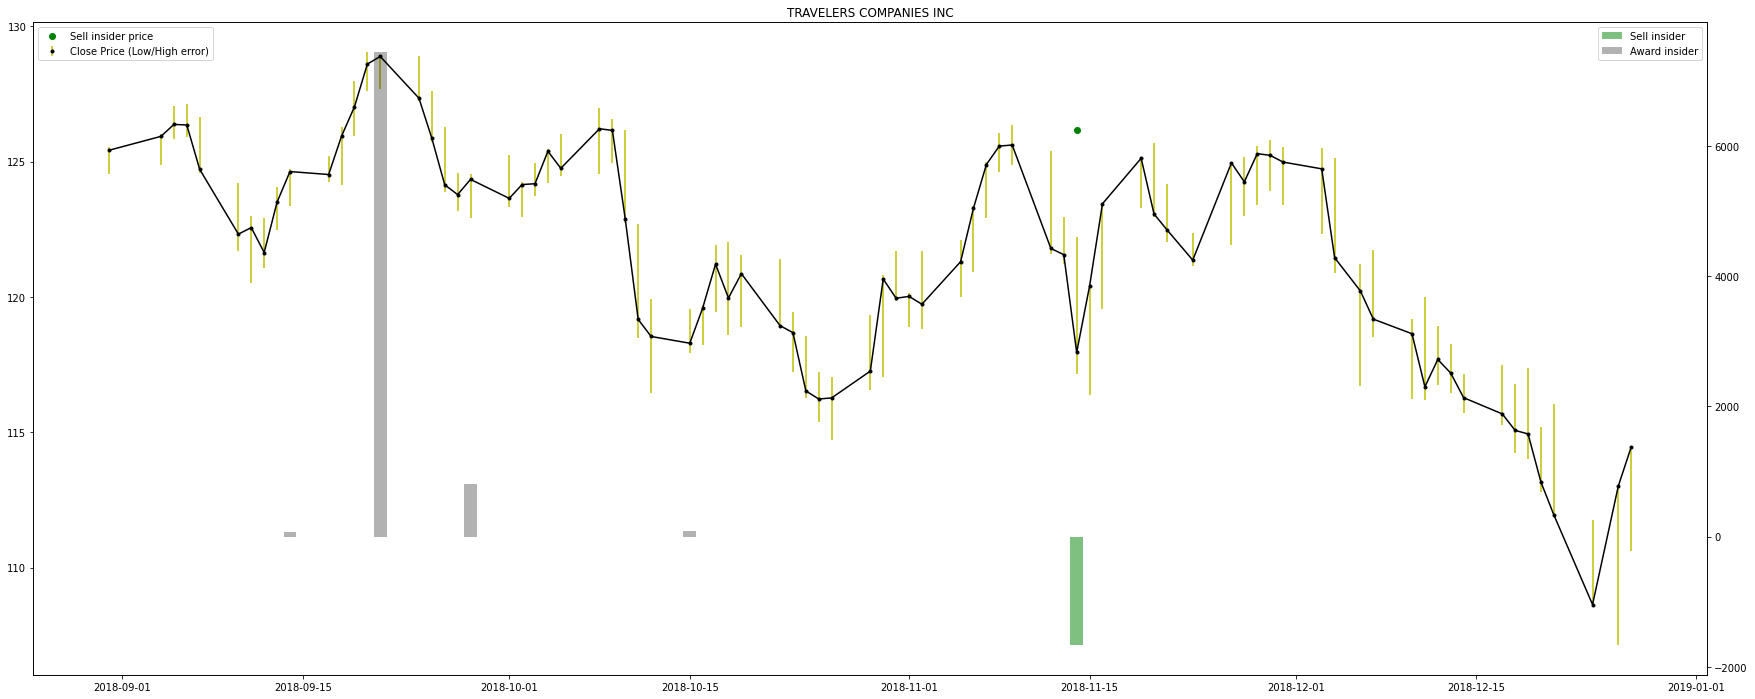

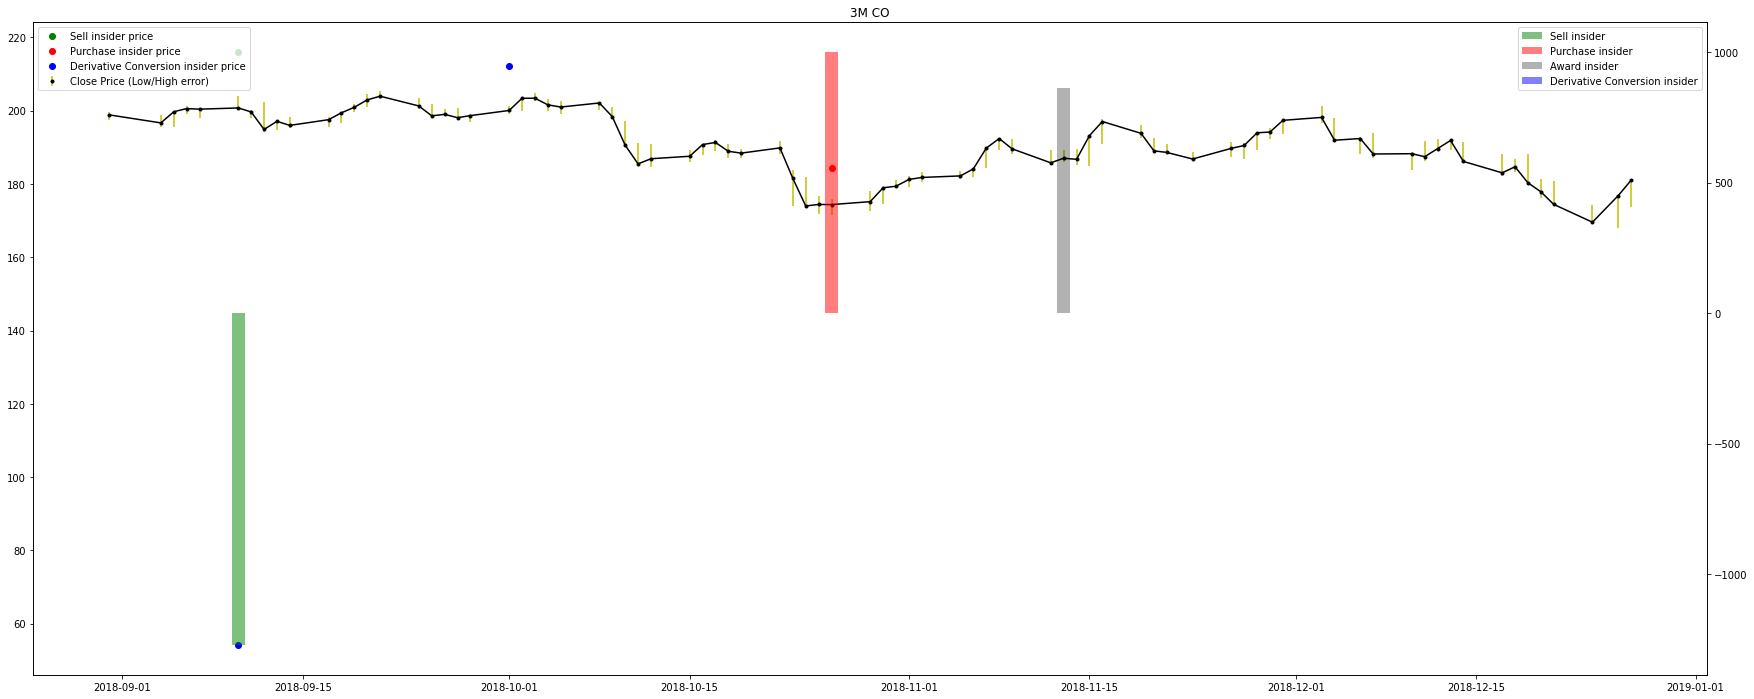

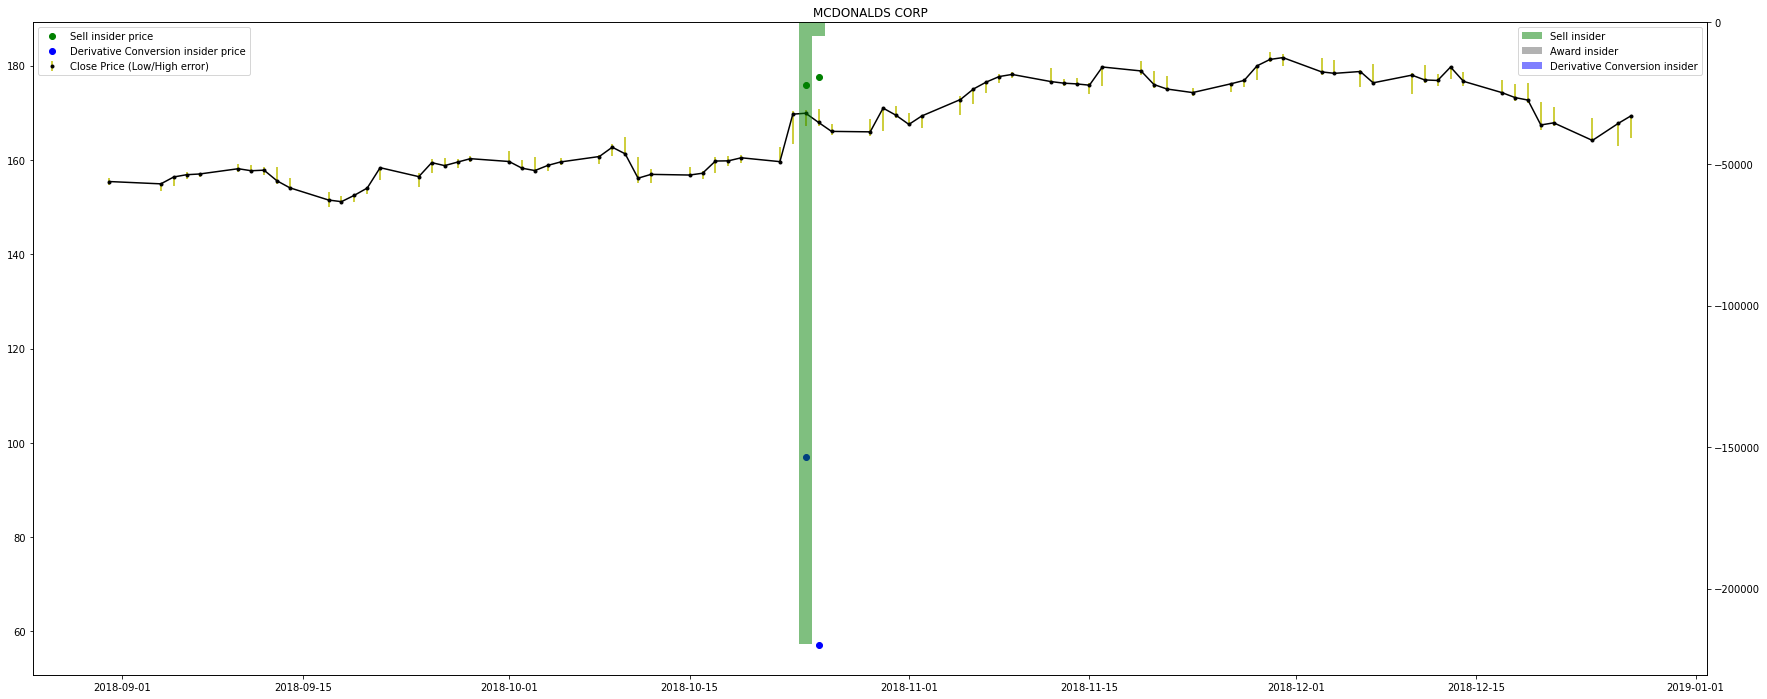

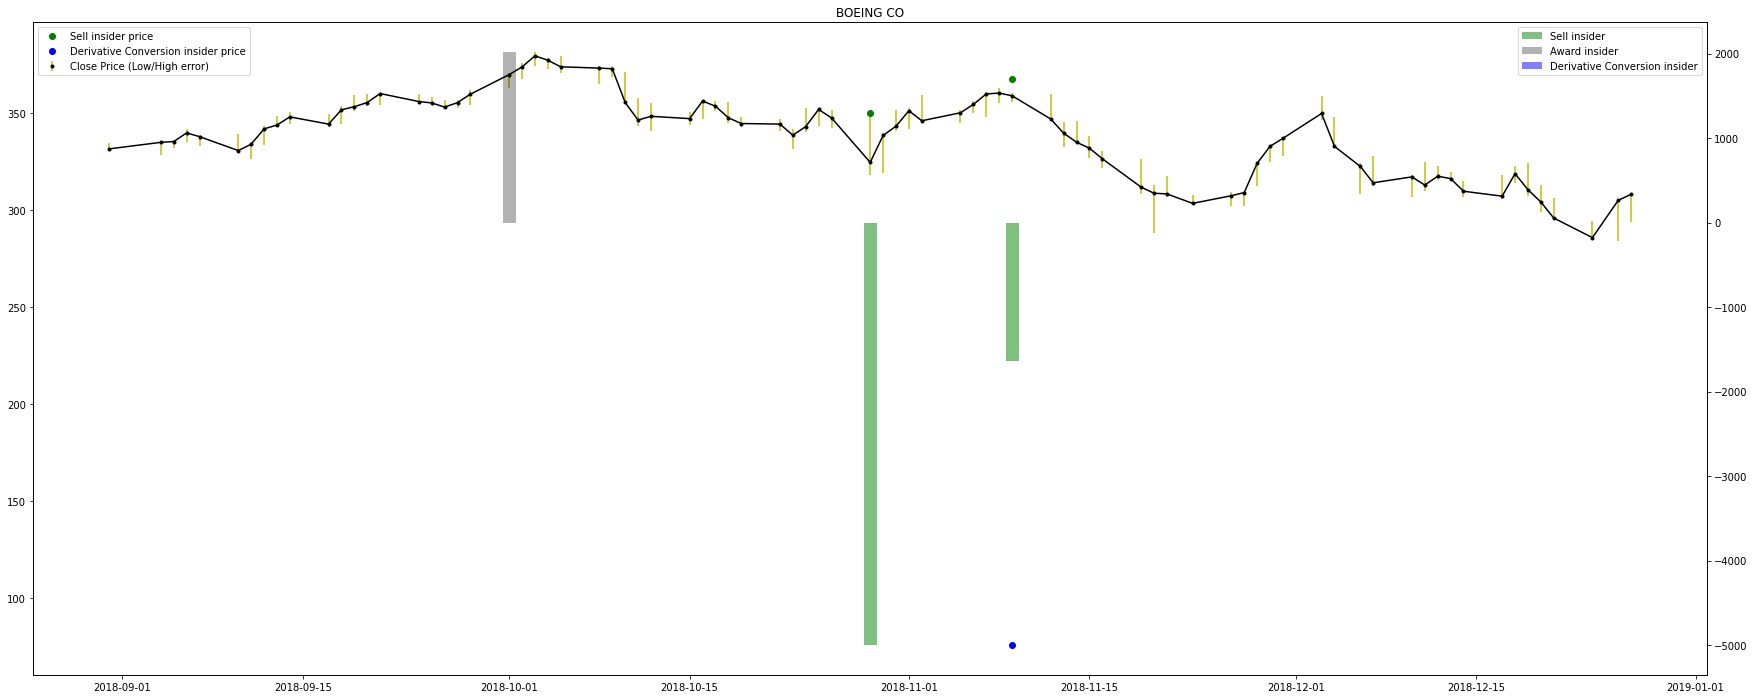

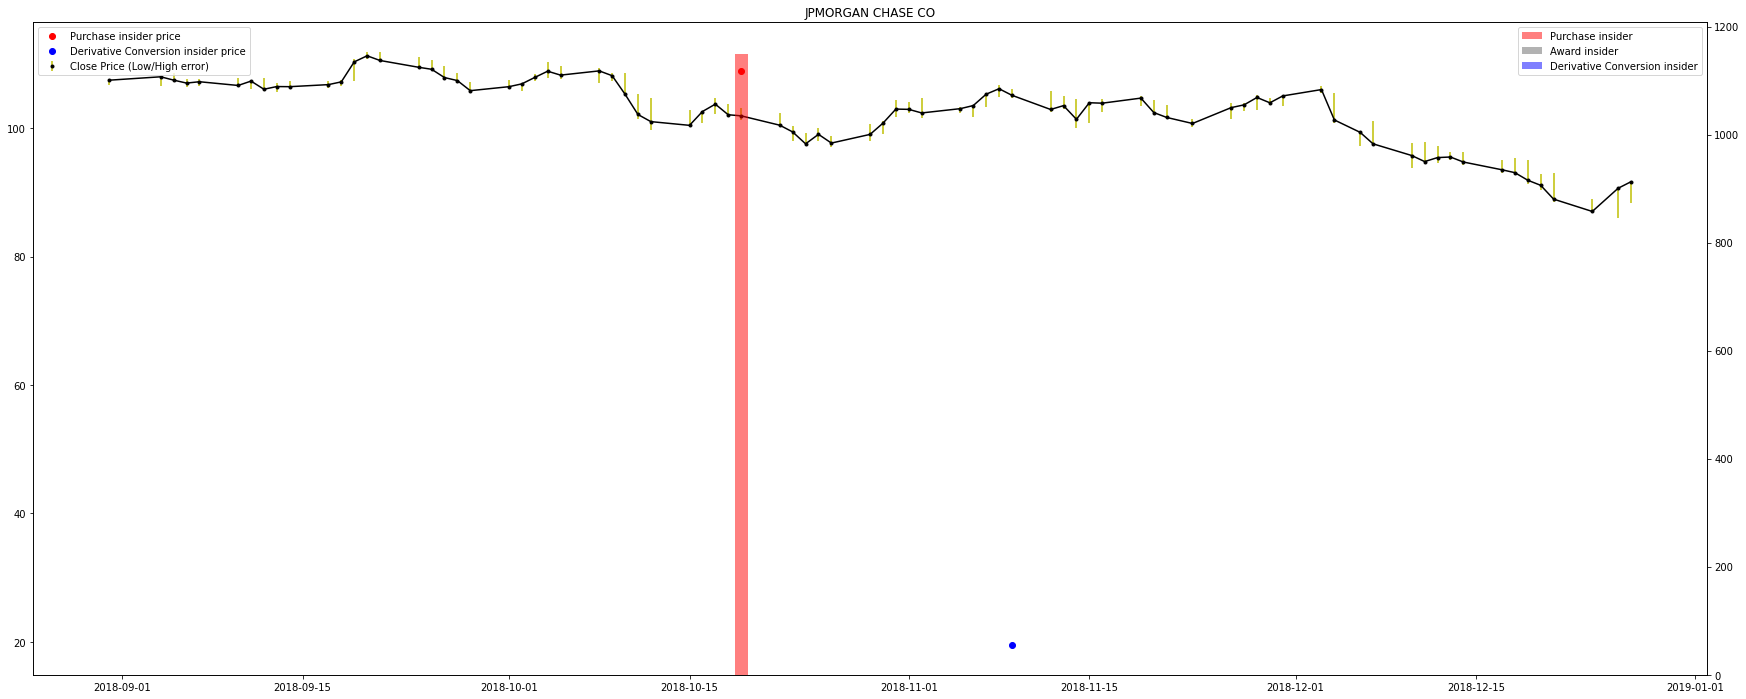

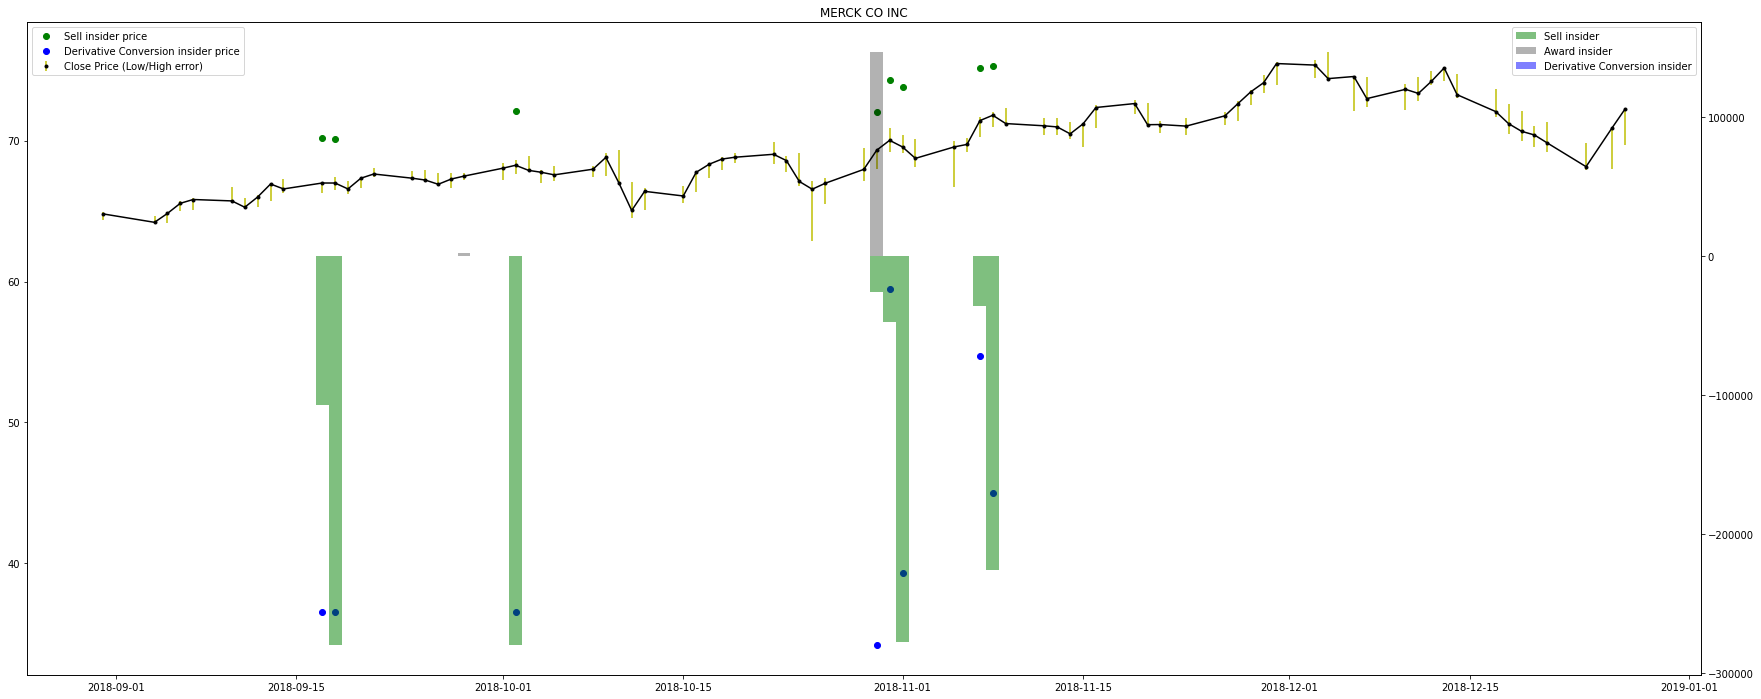

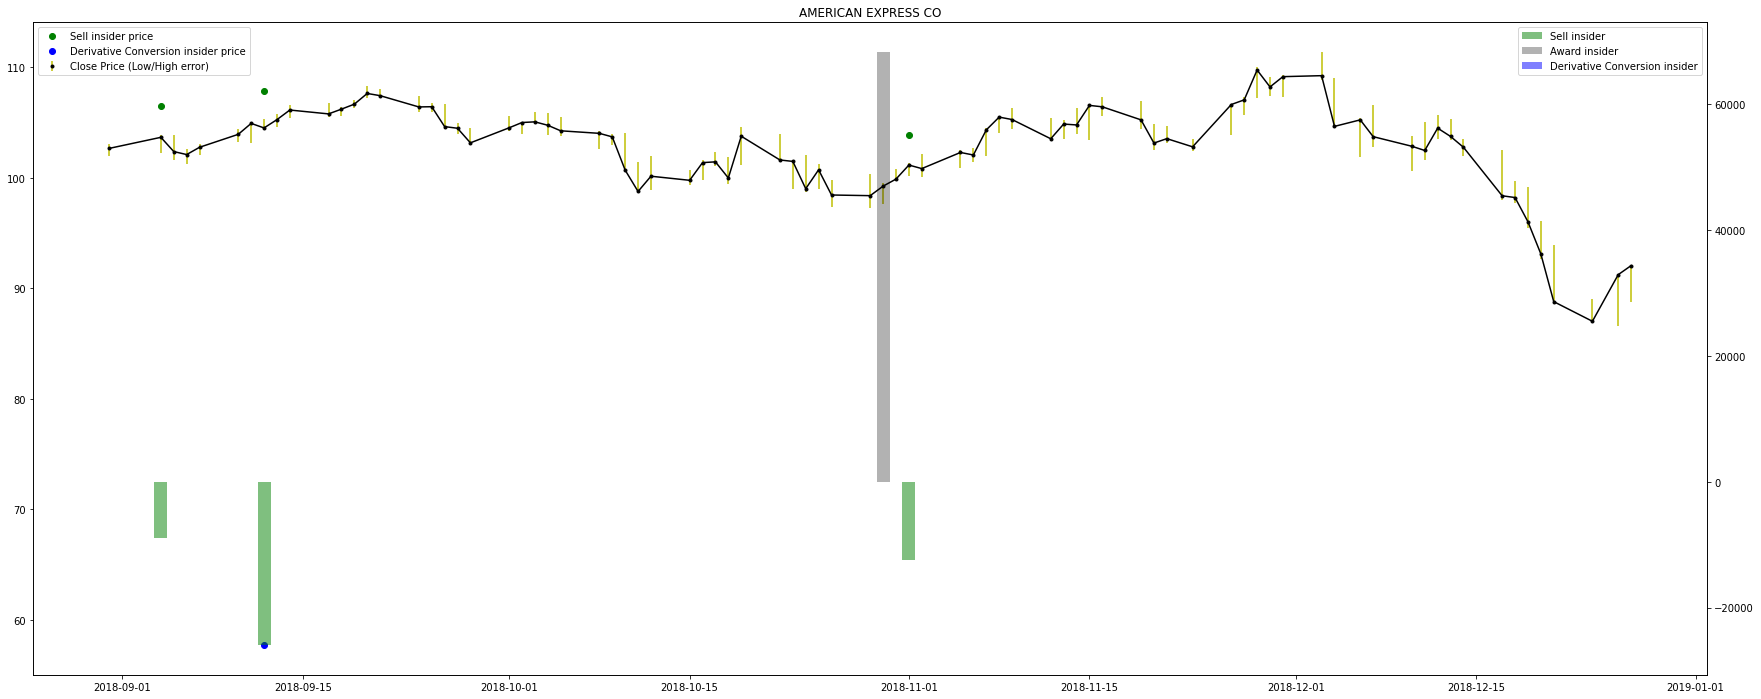

In [11]:
tot_columns = set()
for key, val in dict_frames.items():
    val = val.drop(columns=["Dividends", "Stock Splits"])
    fig, ax1 = plt.subplots(figsize=(30,12))
    ax2 = ax1.twinx()
    ax1.plot(val["Close"], color="k")
    ax1.errorbar(val.index, val["Close"], yerr=[val["Close"]-val["Low"], val["High"]-val["Close"]], fmt=".",
                 color="k", ecolor='y', capthick=2, label="Close Price (Low/High error)")
    if "S_transactionpricepershare" in val.columns:
        ax1.plot(val.index, val["S_transactionpricepershare"], "o", color="g", label="Sell insider price")
    if "P_transactionpricepershare" in val.columns:
        ax1.plot(val.index, val["P_transactionpricepershare"], "o", color="r", label="Purchase insider price")
    if "M_transactionpricepershare" in val.columns:
        ax1.plot(val.index, val["M_transactionpricepershare"], "o", color="b", label="Derivative Conversion insider price")
    ax1.legend(loc=2)        
    #ax2.bar(val.index, val["Volume"], 1, alpha=0.1, color="b", label="Volume")
    if "S_transactionshares" in val.columns:
        ax2.bar(val.index, val["S_transactionshares"], 1, alpha=0.5, color="g", label="Sell insider")
    if "P_transactionshares" in val.columns:
        ax2.bar(val.index, val["P_transactionshares"], 1, alpha=0.5, color="r", label="Purchase insider")
    if "A_transactionshares" in val.columns:
        ax2.bar(val.index, val["A_transactionshares"], 1, alpha=0.3, color="k", label="Award insider")
    if "M_transactionshares" in val.columns:
        ax2.bar(val.index, val["M_transactionshares"], 1, alpha=0.5, color="b", label="Derivative Conversion insider")
    ax2.legend(loc=1)
    #plt.boxplot(data, positions=x, notch=True)
    tot_columns = tot_columns.union(set(val.columns))
    plt.title(ticker2name[key])
    plt.show()

### Saving complete dataframes

{'WMT':               Open    High     Low   Close    Volume  Dividends  Stock Splits  S_transactionpricepershare  A_transactionshares  S_transactionshares  A_transactionvalue  S_transactionvalue
 Date                                                                                                                                                                                       
 2018-08-31   92.95   93.19   91.90   92.63   6324700       0.00             0                         NaN                  NaN                  NaN                 NaN                 NaN
 2018-09-04   92.57   93.02   92.03   92.14   8280700       0.00             0                         NaN                  NaN                  NaN                 NaN                 NaN
 2018-09-05   92.44   93.57   92.14   93.36   9474600       0.00             0                   95.705000                  NaN            -691500.0                 NaN          66180009.0
 2018-09-06   93.28   93.46   92.77   93.20   61

In [13]:
list_df = []
for key, val in dict_frames.items():
    val["ticker"] = key
    list_df.append(val)

In [16]:
complete_df = pd.concat(list_df)
complete_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,S_transactionpricepershare,A_transactionshares,S_transactionshares,A_transactionvalue,S_transactionvalue,ticker,A_transactionpricepershare,M_transactionpricepershare,M_transactionshares,M_transactionvalue,P_transactionpricepershare,P_transactionshares,P_transactionvalue
Date,,,,,,,,,,,,,,,,,,,,
2018-08-31,92.95,93.19,91.90,92.63,6324700,0.0,0,NaN,NaN,NaN,NaN,NaN,WMT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-04,92.57,93.02,92.03,92.14,8280700,0.0,0,NaN,NaN,NaN,NaN,NaN,WMT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-05,92.44,93.57,92.14,93.36,9474600,0.0,0,95.705,NaN,-691500.0,NaN,66180009.0,WMT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-06,93.28,93.46,92.77,93.20,6150800,0.0,0,96.305,NaN,-12111.0,NaN,1166350.0,WMT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-07,92.57,93.23,92.42,92.60,6672400,0.0,0,NaN,NaN,NaN,NaN,NaN,WMT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
data_path = os.path.join(os.getcwd(), "..", "data")
complete_df_path = os.path.join(data_path, "complete_quandl.csv")

In [21]:
complete_df.to_csv(complete_df_path)